# Group 1 Notebook

Objective: analysis of the neuronal activation in different areas of the visual cortex when the subject is presented with visual stimuli of the kind "static gratings".
Areas of the visual cortex: 
- primary visual cortex VISp
- lateromedial area VISl
- rostrolateral area VISrl
- anterolateral area VISal
- posteromedial area VISpm
- anteromedial area VISam

This includes:
- studying single neuron activations as functions of the different static gratings parameters (using spike times, firing rate, spike count, spike rate, tuning curve)
- searching for similarities in the activation patterns of neurons in the same area

## 0. Init

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from collections import defaultdict

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

/Users/lucaraffo/opt/anaconda3/envs/envallen/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = "./allendata"
manifest_path = os.path.join(data_dir, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

In [3]:
session_id = 798911424
oursession = cache.get_session_data(session_id, timeout=3000)

/Users/lucaraffo/opt/anaconda3/envs/envallen/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/Users/lucaraffo/opt/anaconda3/envs/envallen/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  return func(args[0], **pargs)


## 1. Introduction
Selecting brain areas and stimulus type

In [4]:
vc = oursession.units['ecephys_structure_acronym'].value_counts()
visual_cortex = ['VISam', 'VISp', 'VISal', 'VISl', 'VISrl', 'VISpm']
for area in visual_cortex:
    count = vc[area] if area in vc else 0
    print(area + ' ' + str(count))


/Users/lucaraffo/opt/anaconda3/envs/envallen/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/Users/lucaraffo/opt/anaconda3/envs/envallen/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  return func(args[0], **pargs)
/Users/lucaraffo/opt/anaconda3/envs/envallen/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/Users/lucaraffo/opt/anaconda3/envs/envallen/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  return func(args[0], **pargs)


VISam 135
VISp 94
VISal 89
VISl 78
VISrl 47
VISpm 0


In [5]:
static_gratings = oursession.get_stimulus_table("static_gratings")

print(f"Number of static gratings experiments: {static_gratings.shape[0]}")

/Users/lucaraffo/opt/anaconda3/envs/envallen/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/Users/lucaraffo/opt/anaconda3/envs/envallen/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  return func(args[0], **pargs)


Number of static gratings experiments: 6000


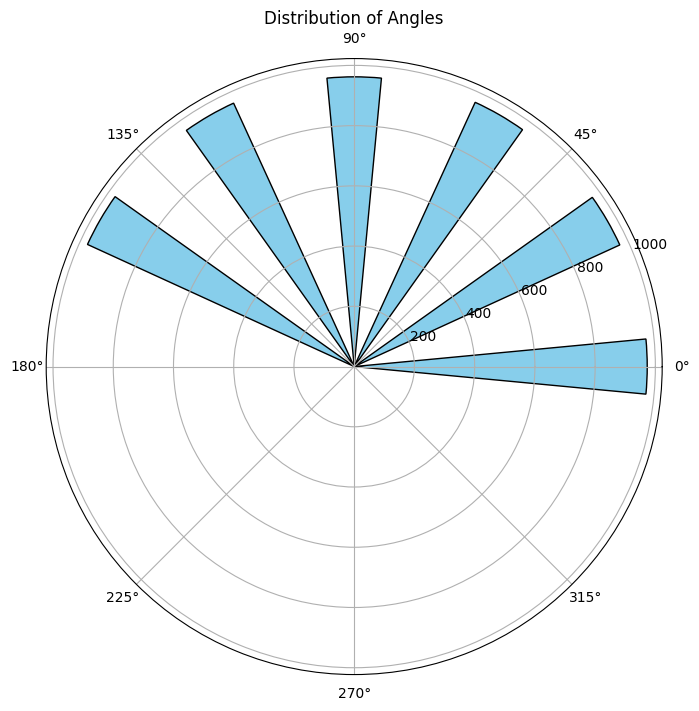

In [6]:
# orientation

angles = static_gratings['orientation'].replace('null', np.nan, inplace=False)
angles.dropna(inplace = True)
count = angles.value_counts()
angles = angles.unique()
angles_deg = np.radians(angles)

# Polar plot
plt.figure(figsize=(8, 8))
plt.subplot(111, polar=True)

width = 3 * np.pi / 50
bars = plt.bar(angles_deg, count, width=width, color='skyblue', edgecolor='black')

plt.title('Distribution of Angles')
plt.show()

In [7]:
# phase
static_gratings['phase'].value_counts()

0.25    1460
0.0     1451
0.5     1450
0.75    1445
null     194
Name: phase, dtype: int64

In [8]:
# frequency
static_gratings['spatial_frequency'].value_counts()

0.02    1165
0.08    1165
0.32    1165
0.16    1158
0.04    1153
null     194
Name: spatial_frequency, dtype: int64

## Single neurons activations

### 2.1 Visualizing neural response

In [9]:
from f import load_data, spike_average_by_parameter, spike_average_by_parameter

In [10]:
parameters_dict, spikes, unit_ids = load_data(session_id)

Plotting spike counts per neuron as function of orientation and spatial frequency. \
We consider average spike count over the different trials of that orientation and spatial frequency. \
This plot gives an understanding of which static gratings parameters activate the neuron.

In [11]:
# code for the plot

def data_neuron_polar(id, area):
    '''
    Function processing data relative to a neuron 
    so that a polar plot for neuron activation can be made.
    id = neuron id.
    '''
    spike_counts_per_stimulus = spike_average_by_parameter(parameters_dict, spikes, id)

    data = dict()

    for k, v in spike_counts_per_stimulus.items():
        spatial_freq = k[2]
        spatial_freq_log = log(spatial_freq, 30)
        data[k] = [k[0], k[1], k[2], spatial_freq_log, v*50]

    df = pd.DataFrame.from_dict(data, columns=['phase', 'orientation', 'spatial_frequency', 'log_spatial_frequency', 'count'], orient='index')

    return df


def log(vec, n):
    '''
    Utils.
    '''
    for i in range(n):
        vec = np.log(vec + 1)
    return vec


def plot_neuron_polar(id, area, df):
    ''' 
    Function plotting data in a polar plot for neuron activation.
    '''
    color_scale = [(0, 'rgba(255, 182, 193, 0.2)'),  # light color for low counts
                    (0.33, 'rgba(255, 102, 102, 0.5)'),
                    (0.66, 'rgba(255, 52, 52, 0.5)'),
                    (1, 'rgba(255, 0, 0, 1)')]   # darker color for high counts

    fig = px.scatter_polar(df, r="log_spatial_frequency", theta="orientation", size_max=15,
                            size=np.full(len(df), 10),
                            color="count",  
                            color_continuous_scale=color_scale,  
                            range_theta=[25, 180],
                            start_angle=180,
                            direction="clockwise",
                            hover_data={'spatial_frequency': True, 'log_spatial_frequency': False})
    
    fig.update_layout(
            polar=dict(
                radialaxis=dict(
                    visible = True,
                    tickvals=sorted(list((set(df['log_spatial_frequency'])))),
                    ticktext=sorted(list((set(df['spatial_frequency'])))),
                    showline=True,  
                    showgrid=True,  
                    gridwidth = 1
                ),
                angularaxis=dict(
            
                    tickmode='array',
                    tickvals=[-360, -330, -300, -270, -240, -210],
                    ticktext=['0°', '30°', '60°', '90°', '120°', '150°'],
                    visible = True,
                    showline=True,  
                    showgrid=True, 
                    gridcolor = 'lightgrey',
                    gridwidth = 1,
                )
            )
        )

    fig.update_layout(title=f'Neuron id: {id};  Neuron area: {area}')

    fig.show()  

Here we plot the activation of one given neuron as a function of frequency and spatial orientation. We sum over trials with different phase but same frequency and spatial orientation.

In [12]:
id = 951092369
area = oursession.units.loc[id, 'ecephys_structure_acronym']
df = data_neuron_polar(id, area)
df = df.groupby(['orientation', 'spatial_frequency', 'log_spatial_frequency'], as_index=False)['count'].sum()
plot_neuron_polar(id, area, df)

Here we do the same thing, but instead of plotting the sum over trials with different phase and same orientation and spatial frequency, we create a plot for each different phase.

In [13]:
id = 951092369
area = oursession.units.loc[id, 'ecephys_structure_acronym']
df = data_neuron_polar(id, area)
phase = [0.00, 0.25, 0.5, 0.75]
for ph in phase:
    df_ph = df[df['phase'] == ph]
    plot_neuron_polar(id, area, df_ph)

It can be observed that:
- the max spike count is always around 280/300 for all the four different values of phase;
- there is a slightly different activation pattern as the phase changes, suggesting that neuronal activation is not conditionally independent from phase given spatial frequency and orientation. 

We can conclude that the parameter phase affects neuronal activation but not as much as spatial frequency and orientation.

## 2.2 Significance of Tuning Curves

Here we should study tuning curves of single neurons as function of each single parameter (phase, orientation, spatial frequency).

In particular, we will procede as following:

1) We fix a neuron
2) We fix a class of parameters (one between phase, orientation and spatial frequency), that we will call special_param
3) We find which are the values in special_param that obtain the highest and the lowest spike count sum (over trials) \
We call these two values high and low respectively.
4) For both high and low, we create a list of spikes. Where each list index is a static grating trial (with phase = high or low).
5) We perform a coupled T-Test to check whether high consistently triggers more spikes than low among the trials
6) We repeat everything for every class of parameters
7) We repeat everything for every neuron

In [14]:
from f import spike_count_per_trial, spike_sum_by_parameter

In [15]:
# finding minimum number of trials so that we consider for each static gratings type the same amount of trials
min_number_trials = 60
for k, v in parameters_dict.items():
    min_number_trials = min(min_number_trials, len(v))
min_number_trials

44

In [16]:
# Preliminary functions

def spike_count_special_param_by_unit(parameters_dict, spikes, unit_id, special_param):
    """
    This function takes as input a neuron and a class of parameters (i.e. phase, orientation and spatial frequency), 
    identified by the variable special_param.
    The function returns, for each value of the special_param, the sum over spike counts, among all the trials.
    """
    result = {}
    
    dict_by_unit = spike_sum_by_parameter(parameters_dict, spikes, unit_id)

    for key in dict_by_unit.keys():
        value_special = float(key[special_param])
        result[value_special] = result.get(value_special, 0) + int(dict_by_unit[key])

    return result


def trials_special_param_by_unit(parameters_dict, spikes, unit_id, special_param):
    """
    This function takes a neuron and a special_param. 
    Then it finds the two values in special_param that trigger the largest (high) and the smallest (low) spike count among all the trials.
    Then it returns two vectors: the number of spikes for each trial where special_param is high, or low. 
    """
    special = spike_count_special_param_by_unit(parameters_dict, spikes, unit_id, special_param)
    high = max(special, key = special.get)
    low = min(special, key = special.get)

    high_vec = []
    low_vec = []
    parameters_dict2 = parameters_dict.copy()

    for params in parameters_dict2:
        if params[special_param] == high:
            high_vec_temp = spike_count_per_trial(parameters_dict2, spikes, unit_id, params)
            params_new = list(params).copy()
            params_new[special_param] = low
            low_vec_temp = spike_count_per_trial(parameters_dict2, spikes, unit_id, tuple(params_new))
            if len(high_vec_temp) > 45 and len(low_vec_temp) > 45:
                high_vec += high_vec_temp[:44]
                low_vec += low_vec_temp[:44]

    return high_vec, low_vec

We perform a T-Test to check whether the number of spikes "triggered" by high is consistently higher 
than the number of spikes triggered by "low", among the trials. 

This code snippet performs the t-test only for one neuron.

In [17]:
from scipy.stats import ttest_ind


# name = {0: "phase", 1: "orientation", 2: "spatial frequency"}

def t_test_special(parameters_dict, spikes, unit_id):
    p_values = []
    for i in range(3):
        high, low = trials_special_param_by_unit(parameters_dict, spikes, unit_id, i)
        t_stat, p_value = ttest_ind(high, low)
        p_values.append(p_value)
    return p_values

In [18]:
first_unit = unit_ids[2]

name = {0: "phase", 1: "orientation", 2: "spatial frequency"}
p_values = t_test_special(parameters_dict, spikes, first_unit)
for i in range(3):
    print("parameter " + name[i] + " = " + str(p_values[i]))

parameter phase = 0.12178918887147491
parameter orientation = 0.0014789294004684652
parameter spatial frequency = 0.015414697435822106


In [19]:
for area in visual_cortex:
    n_significant_units_phase = 0
    n_significant_units_orient = 0
    n_significant_units_freq = 0

    units_in_area = oursession.units[oursession.units['ecephys_structure_acronym'] == area].index.values
    if len(units_in_area) == 0:
        continue

    for unit in units_in_area:
        p_values = t_test_special(parameters_dict, spikes, unit)
        if p_values[0] < 0.05:
            n_significant_units_phase +=1
        if p_values[1] < 0.05:
            n_significant_units_orient +=1
        if p_values[2] < 0.05:
            n_significant_units_freq +=1
    
    perc_signficant_units_phase = n_significant_units_phase / len(units_in_area)
    perc_signficant_units_orient = n_significant_units_orient / len(units_in_area)
    perc_signficant_units_freq = n_significant_units_freq / len(units_in_area)

    print(f"Percentage significant units for phase in {area}", perc_signficant_units_phase)
    print(f"Percentage significant units for orient in {area}", perc_signficant_units_orient)
    print(f"Percentage significant units for freq in {area}", perc_signficant_units_freq)
    print("\n\n")

Percentage significant units for phase in VISam 0.2518518518518518
Percentage significant units for orient in VISam 0.9037037037037037
Percentage significant units for freq in VISam 0.9333333333333333



Percentage significant units for phase in VISp 0.6170212765957447
Percentage significant units for orient in VISp 0.9787234042553191
Percentage significant units for freq in VISp 0.9893617021276596



Percentage significant units for phase in VISal 0.3707865168539326
Percentage significant units for orient in VISal 0.9438202247191011
Percentage significant units for freq in VISal 0.9887640449438202



Percentage significant units for phase in VISl 0.4358974358974359
Percentage significant units for orient in VISl 0.9230769230769231
Percentage significant units for freq in VISl 0.9487179487179487



Percentage significant units for phase in VISrl 0.425531914893617
Percentage significant units for orient in VISrl 0.9148936170212766
Percentage significant units for freq in VISrl 0.8936170

## Comparison of activation of neurons in different brain areas

## 2.3 Exploratory Data Analysis

### Outlier detection and removal

We need to understand if in our experiment there are some neurons that can be considered 'outliers', showing unusual activation patterns.

We create a dataframe that contains on the rows the ids of the neurons and on the columns the index of the static grating that is presented: at position (i, j) it contains the average spike counts over trials of neuron i when static grating j is presented.

In [20]:
stimulus_trials = static_gratings.groupby(['phase','orientation','spatial_frequency']).agg({
    'start_time': lambda x: list(x),
    'stop_time': lambda x: list(x)
}).reset_index().drop(index=120)

In [21]:
def get_spike_count(session, stimulus_trials, unitid, stimulusindex):
    """
    Filter neurons in the desired region
    IDs of these neuron are set as the indices of the units table
    Get the spike times as a list of numpy arrays instead of dictionary
    spike_times[id] is a numpy array
    """
    row = stimulus_trials.iloc[stimulusindex, :]
    start_times = row['start_time']
    stop_times = row['stop_time']

    trial_spikes = []
    for ind, trial_start in enumerate(start_times):
        spikes = session.spike_times[unitid]
        spikes_per_trial = spikes[(spikes > trial_start) & (spikes < stop_times[ind])]
        trial_spikes.append(len(spikes_per_trial))

    return trial_spikes

# average spike count over trials of same kind per neuron
def get_spike_per_stimulus_over_trials(session, stimulus_trials, unitid):
    stimulus_counts = []

    for i in range(120):
        count = get_spike_count(session,stimulus_trials,unitid,i)
        stimulus_counts.append(sum(count)/len(count))

    return stimulus_counts

In [22]:
units = oursession.units
units_labels = units["ecephys_structure_acronym"]

In [23]:
data_dict = dict()
n_units = len(unit_ids) 
for unit_id in unit_ids:
    data_dict[unit_id] = get_spike_per_stimulus_over_trials(oursession, stimulus_trials, unit_id)

In [24]:
df = pd.DataFrame(data_dict)
# it contains on the columns the ids of the neurons and on the rows the index of the static grating that is presented.
# at position (i, j) it contains the average spike counts over trials of neuron j when static grating i is presented
df

951088679  951088664  951088734  951088721  951088862  951088823  \
0     2.204082   1.734694   0.469388   2.673469   4.367347   1.857143   
1     1.612245   1.571429   0.408163   3.142857   3.693878   1.612245   
2     2.040816   2.040816   0.204082   3.367347   4.714286   1.714286   
3     1.857143   1.714286   0.265306   3.897959   4.428571   1.510204   
4     1.653061   2.183673   0.183673   4.000000   4.469388   1.530612   
..         ...        ...        ...        ...        ...        ...   
115   1.775510   1.693878   0.244898   3.102041   4.510204   1.714286   
116   2.000000   1.791667   0.145833   2.979167   4.145833   1.500000   
117   1.604167   2.229167   0.187500   2.395833   4.020833   1.375000   
118   1.755102   2.306122   0.612245   3.102041   3.836735   1.877551   
119   2.061224   2.285714   0.306122   3.224490   4.591837   1.755102   

     951088891  951088957  951088948  951088939  ...  951116953  951117426  \
0     0.571429   1.204082  12.551020   1.102041  ...   2.510204   0.163265   
1     0.265306   0.795918  12.571429   1.102041  ...   0.755102   0.102041   
2     0.408163   0.938776  12.918367   1.224490  ...   0.346939   0.040816   
3     0.367347   0.918367  12.469388   1.102041  ...   0.326531   0.122449   
4     0.265306   0.938776  13.857143   1.142857  ...   0.551020   0.183673   
..         ...        ...        ...        ...  ...        ...        ...   
115   0.204082   0.673469  13.020408   0.755102  ...   8.183673   0.040816   
116   0.354167   0.916667  12.458333   1.270833  ...   1.604167   0.125000   
117   0.250000   0.875000  12.437500   1.083333  ...   0.250000   0.041667   
118   0.367347   1.122449  12.387755   1.204082  ...   0.326531   0.040816   
119   0.469388   0.979592  12.000000   1.265306  ...   1.000000   0.061224   

     951116991  951117004  951117090  951117435  951117571  951117127  \
0     1.408163   0.081633   9.102041   0.224490   0.061224   4.020408   
1     0.408163   0.285714   5.142857   0.102041   0.081633   5.387755   
2     0.142857   0.081633   1.653061   0.040816   0.040816   3.265306   
3     0.285714   0.204082   1.755102   0.020408   0.000000   1.877551   
4     0.489796   0.387755   1.632653   0.122449   0.020408   1.673469   
..         ...        ...        ...        ...        ...        ...   
115   1.795918   0.183673   8.489796   0.122449   0.040816   4.918367   
116   0.500000   0.145833   5.541667   0.020833   0.125000   5.979167   
117   0.125000   0.145833   2.791667   0.000000   0.062500   4.229167   
118   0.163265   0.224490   2.510204   0.040816   0.061224   2.775510   
119   0.183673   0.591837   2.387755   0.142857   0.061224   1.673469   

     951117121  951117155  
0     3.163265   0.285714  
1     2.244898   0.204082  
2     1.306122   0.122449  
3     0.775510   0.020408  
4     0.959184   0.183673  
..         ...        ...  
115   2.693878   0.163265  
116   2.000000   0.062500  
117   1.229167   0.062500  
118   0.714286   0.040816  
119   0.836735   0.142857  

[120 rows x 825 columns]

In [25]:
df_t = df.transpose()
# it contains on the rows the ids of the neurons and on the columns the index of the static grating that is presented.
# at position (i, j) it contains the average spike counts over trials of neuron i when static grating j is presented

In [26]:
df_t["labels"] = units.ecephys_structure_acronym
df_t["labels"].value_counts()

VISam    135
CA1      134
VISp      94
VISal     89
VISl      78
LP        65
SUB       59
VISrl     47
DG        31
APN       25
CA3       21
NOT       16
LGv       16
ProS       9
CA2        2
TH         2
MB         1
Eth        1
Name: labels, dtype: int64

We filter the dataframe for the desired areas of the visual cortex.

In [27]:
visam = df_t[df_t['labels'] == "VISam"]
visp = df_t[df_t['labels'] == "VISp"]
visal = df_t[df_t['labels'] == "VISal"]
visl = df_t[df_t['labels'] == "VISl"]
visrl = df_t[df_t['labels'] == "VISrl"]

In [28]:
def plot_distrib(df):
    """
    Each plot corresponds to a type of static grating presented. 
    Each displays the number of neurons (count) of one area 
    that have a specific average spike count (on the x axis).
    """
    fig, axs = plt.subplots(12, 10, figsize=(20, 20))

    # Flatten the 2D array of subplots for easy indexing
    axs = axs.flatten()

    # Plot each displot sequentially
    for i in range(120):
        sns.histplot(df[i], ax=axs[i], kde=True, color='skyblue', alpha=0.6)

    # Hide empty subplots if any
    for i in range(120, len(axs)):
        axs[i].axis('off')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()


In [29]:
visam

0         1         2         3         4         5     6  \
951092050  3.530612  3.448980  3.510204  3.183673  3.244898  3.000000  3.14   
951092075  2.142857  1.918367  1.877551  1.795918  1.571429  1.653061  2.10   
951092303  4.551020  3.571429  2.632653  2.979592  3.591837  4.857143  3.88   
951092398  0.387755  0.224490  0.122449  0.061224  0.306122  0.591837  0.90   
951092369  4.836735  4.714286  5.551020  5.387755  5.428571  5.326531  4.44   
...             ...       ...       ...       ...       ...       ...   ...   
951098850  0.204082  0.204082  0.061224  0.306122  0.265306  0.142857  0.06   
951098807  3.163265  3.081633  3.020408  2.489796  2.734694  3.040816  2.18   
951098773  2.510204  4.489796  4.632653  3.918367  4.489796  2.734694  4.20   
951098871  0.224490  0.061224  0.224490  0.204082  0.367347  0.204082  0.38   
951098928  6.142857  8.306122  6.551020  5.448980  5.285714  6.000000  6.56   

                  7         8         9  ...       111       112       113  \
951092050  3.469388  3.775510  3.122449  ...  3.244898  2.897959  3.130435   
951092075  1.714286  2.489796  2.367347  ...  1.530612  1.408163  2.021739   
951092303  2.571429  2.979592  3.816327  ...  3.183673  2.714286  2.869565   
951092398  0.428571  0.265306  0.102041  ...  0.142857  0.367347  0.108696   
951092369  5.367347  5.510204  4.571429  ...  4.489796  4.142857  4.956522   
...             ...       ...       ...  ...       ...       ...       ...   
951098850  0.183673  0.326531  0.265306  ...  0.102041  0.122449  0.130435   
951098807  2.714286  2.877551  2.693878  ...  1.857143  2.489796  1.956522   
951098773  4.591837  4.673469  3.367347  ...  3.244898  4.020408  2.869565   
951098871  0.183673  0.163265  0.244898  ...  0.122449  0.244898  0.086957   
951098928  6.632653  6.775510  4.510204  ...  7.183673  6.877551  5.695652   

                114       115       116       117       118       119  labels  
951092050  4.163265  3.734694  3.375000  3.062500  3.285714  3.346939   VISam  
951092075  1.918367  2.102041  1.979167  1.916667  2.000000  1.959184   VISam  
951092303  3.857143  4.510204  3.937500  2.604167  2.775510  4.489796   VISam  
951092398  0.081633  0.102041  0.020833  0.125000  0.489796  0.326531   VISam  
951092369  4.653061  4.612245  4.937500  4.979167  5.469388  5.020408   VISam  
...             ...       ...       ...       ...       ...       ...     ...  
951098850  0.306122  0.285714  0.083333  0.166667  0.102041  0.448980   VISam  
951098807  2.387755  2.938776  2.958333  2.458333  1.897959  2.836735   VISam  
951098773  2.734694  2.469388  5.041667  4.291667  4.428571  3.306122   VISam  
951098871  0.244898  0.183673  0.520833  0.125000  0.183673  0.224490   VISam  
951098928  5.081633  7.102041  9.416667  6.687500  5.877551  4.938776   VISam  

[135 rows x 121 columns]

In [30]:
visam.describe()

0           1           2           3           4           5    \
count  135.000000  135.000000  135.000000  135.000000  135.000000  135.000000   
mean     1.393046    1.684203    1.904611    1.626909    1.517460    1.403779   
std      1.675068    2.040915    2.251299    1.805883    1.697786    1.604601   
min      0.000000    0.000000    0.020408    0.000000    0.000000    0.000000   
25%      0.244898    0.214286    0.285714    0.295918    0.285714    0.265306   
50%      0.571429    0.632653    0.877551    0.775510    0.775510    0.714286   
75%      2.102041    2.612245    2.775510    2.346939    2.285714    2.000000   
max      7.163265    8.653061    9.367347    8.551020    7.938776    7.387755   

              6           7           8           9    ...         110  \
count  135.000000  135.000000  135.000000  135.000000  ...  135.000000   
mean     1.602667    1.786546    1.696750    1.417385  ...    1.598222   
std      1.889773    2.053807    1.926724    1.560553  ...    1.892186   
min      0.020000    0.000000    0.000000    0.000000  ...    0.000000   
25%      0.250000    0.285714    0.306122    0.285714  ...    0.290000   
50%      0.700000    0.877551    0.877551    0.755102  ...    0.760000   
75%      2.440000    2.612245    2.591837    2.112245  ...    2.360000   
max      7.680000    8.571429    7.959184    7.612245  ...    8.600000   

              111         112         113         114         115         116  \
count  135.000000  135.000000  135.000000  135.000000  135.000000  135.000000   
mean     1.576417    1.599698    1.439936    1.400151    1.500831    1.712191   
std      1.884040    1.804148    1.642107    1.610718    1.779289    2.058305   
min      0.000000    0.040816    0.000000    0.000000    0.000000    0.000000   
25%      0.214286    0.306122    0.260870    0.255102    0.265306    0.229167   
50%      0.653061    0.714286    0.760870    0.734694    0.653061    0.729167   
75%      2.316327    2.500000    2.097826    1.989796    2.163265    2.718750   
max      7.551020    7.326531    7.826087    8.693878    7.102041    9.416667   

              117         118         119  
count  135.000000  135.000000  135.000000  
mean     1.691667    1.559335    1.418594  
std      1.993159    1.796473    1.618016  
min      0.000000    0.020408    0.000000  
25%      0.250000    0.244898    0.255102  
50%      0.645833    0.775510    0.673469  
75%      2.541667    2.306122    2.040816  
max      8.416667    8.122449    7.857143  

[8 rows x 120 columns]

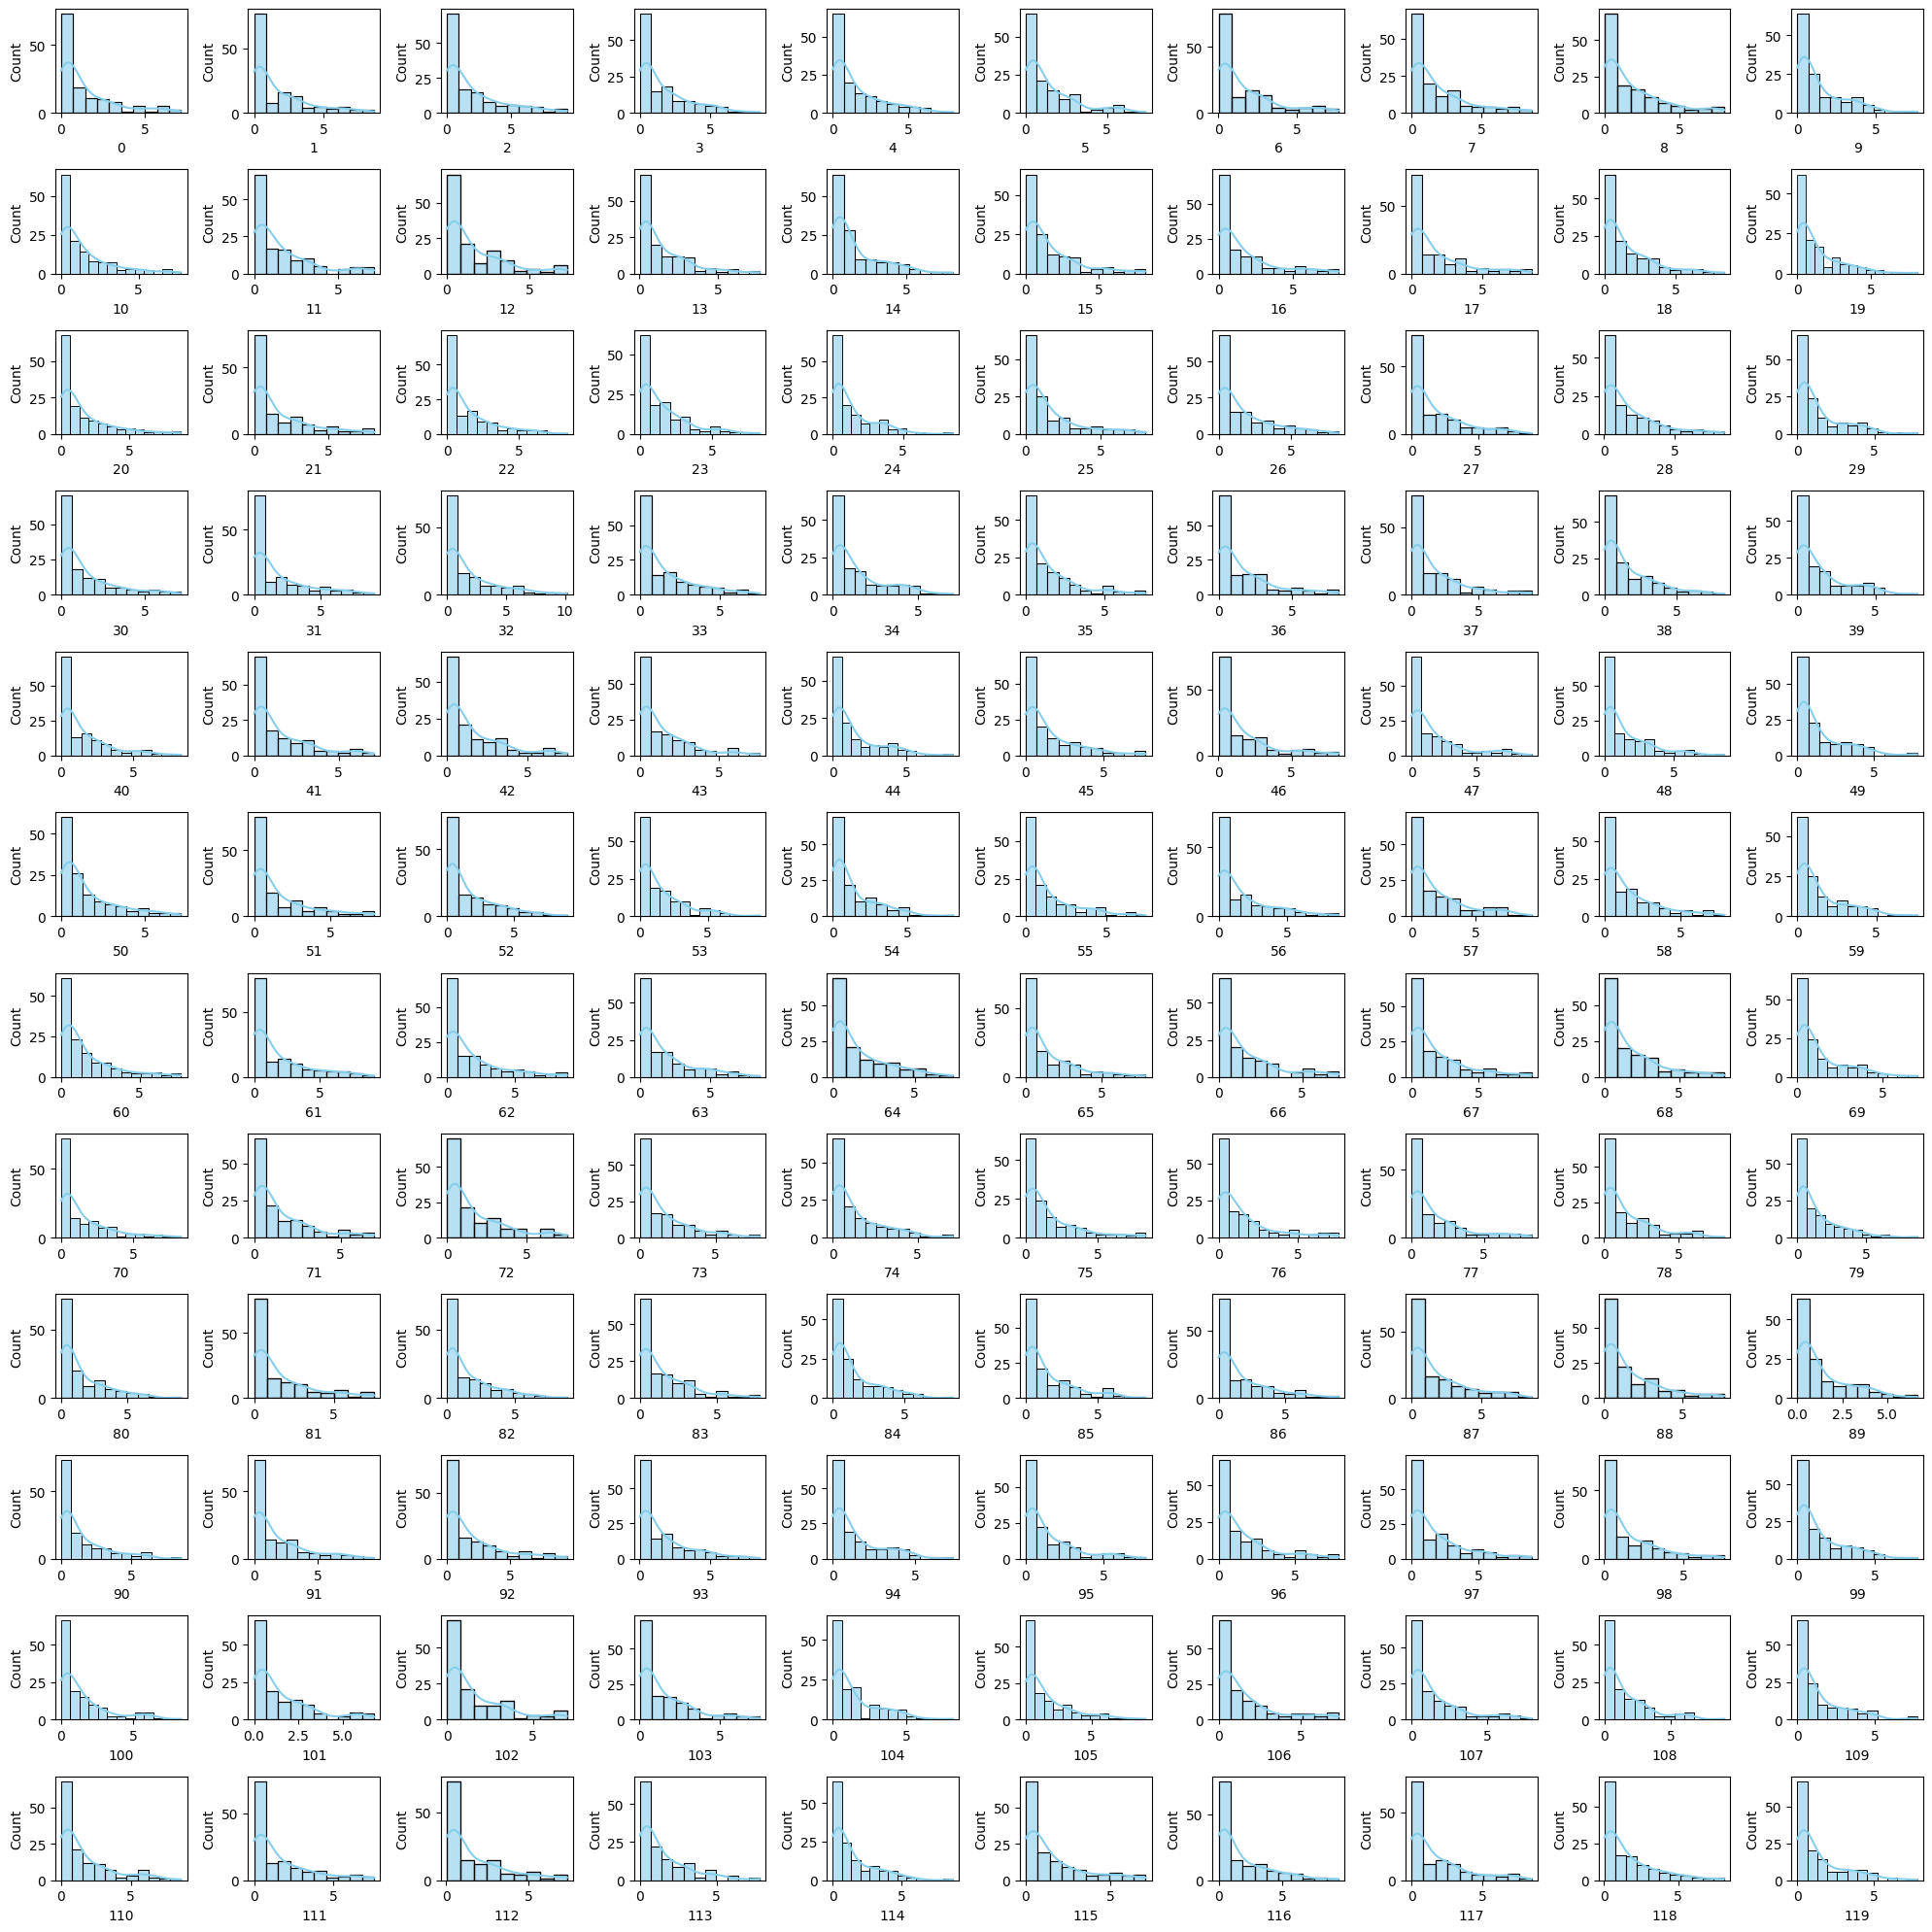

In [31]:
plot_distrib(visam)

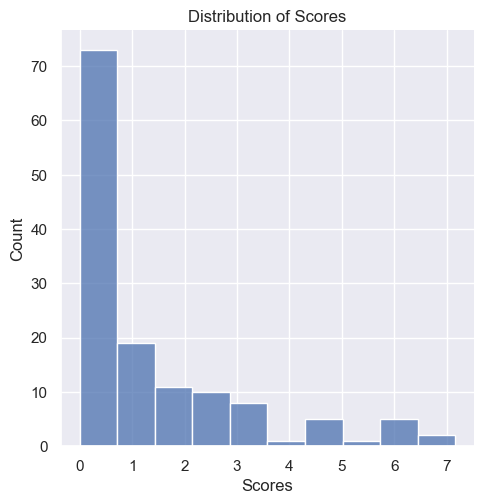

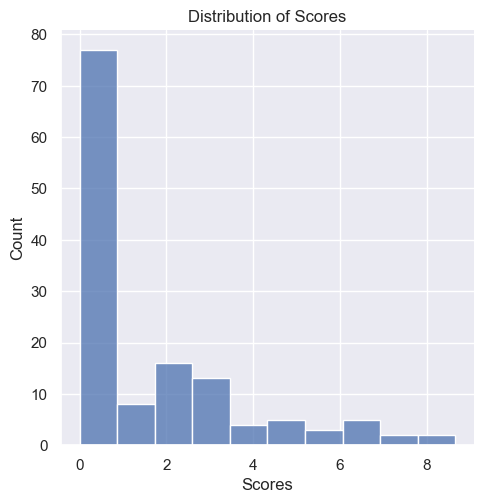

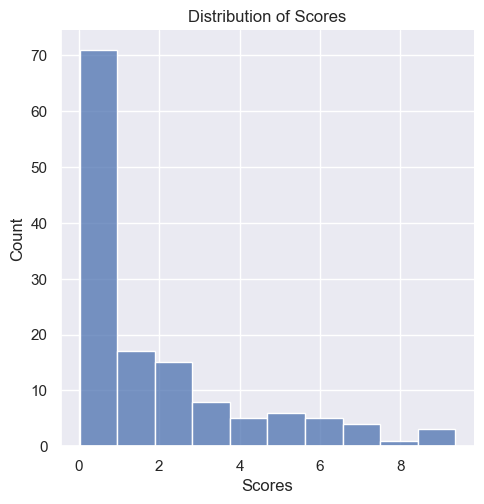

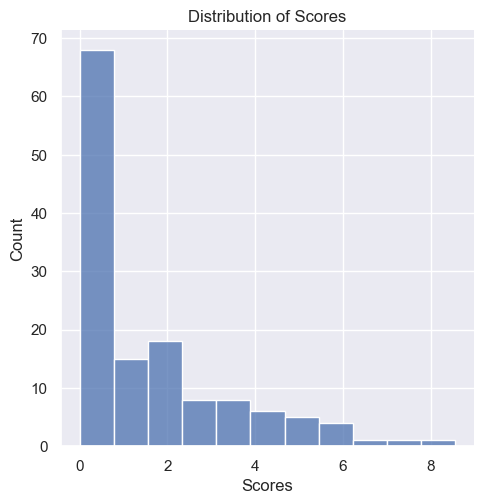

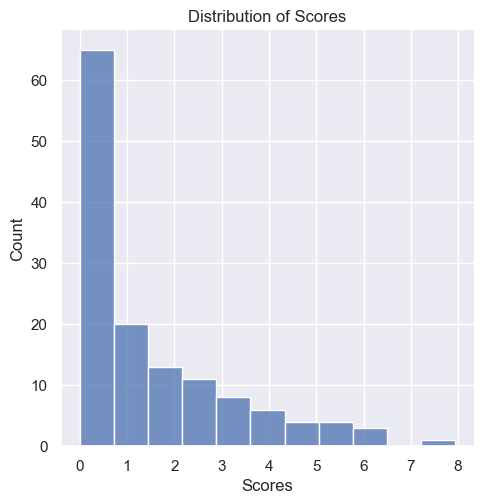

In [32]:
for i in range(5):
    sns.set_theme()
    sns.displot(data=visam[i]).set(title="Distribution of Scores", xlabel="Scores")

In [33]:
visp.describe()
# way more strange distributions... max is very high in many columns 
# also in visp for different static gratings types, the scale of activation differs (different from visam)

0          1          2          3          4          5    \
count  94.000000  94.000000  94.000000  94.000000  94.000000  94.000000   
mean    1.803951   1.762918   1.652410   1.443552   1.476118   1.827399   
std     2.684107   2.449958   2.397649   2.049471   1.846543   2.549064   
min     0.020408   0.000000   0.000000   0.000000   0.020408   0.000000   
25%     0.326531   0.326531   0.229592   0.265306   0.387755   0.352041   
50%     0.765306   0.836735   0.704082   0.683673   0.734694   0.765306   
75%     1.918367   2.265306   2.117347   1.913265   1.704082   2.295918   
max    17.632653  16.795918  14.938776  11.755102   8.346939  13.102041   

             6          7          8          9    ...        110        111  \
count  94.000000  94.000000  94.000000  94.000000  ...  94.000000  94.000000   
mean    1.713404   1.909032   1.650673   1.293530  ...   1.701702   1.778333   
std     2.263212   2.486849   2.341061   1.619068  ...   2.261562   2.382289   
min     0.000000   0.000000   0.000000   0.000000  ...   0.000000   0.000000   
25%     0.240000   0.346939   0.346939   0.326531  ...   0.210000   0.244898   
50%     0.780000   0.877551   0.683673   0.673469  ...   0.820000   0.826531   
75%     2.390000   2.459184   2.000000   1.678571  ...   2.350000   2.750000   
max    13.720000  14.918367  11.673469   7.306122  ...  11.860000  14.142857   

             112        113        114        115        116        117  \
count  94.000000  94.000000  94.000000  94.000000  94.000000  94.000000   
mean    1.622232   1.510638   1.433565   1.824577   1.728502   1.629433   
std     1.985409   1.936752   1.827852   2.609147   2.298622   2.323468   
min     0.000000   0.021739   0.000000   0.000000   0.000000   0.000000   
25%     0.244898   0.195652   0.204082   0.290816   0.276042   0.250000   
50%     0.887755   0.739130   0.714286   0.724490   1.041667   0.687500   
75%     2.239796   2.277174   1.877551   2.280612   2.057292   1.968750   
max    11.489796   8.956522   8.142857  15.102041  11.979167  12.770833   

             118        119  
count  94.000000  94.000000  
mean    1.473513   1.312853  
std     1.982836   1.670495  
min     0.000000   0.000000  
25%     0.244898   0.290816  
50%     0.642857   0.673469  
75%     1.959184   1.688776  
max    10.061224   7.612245  

[8 rows x 120 columns]

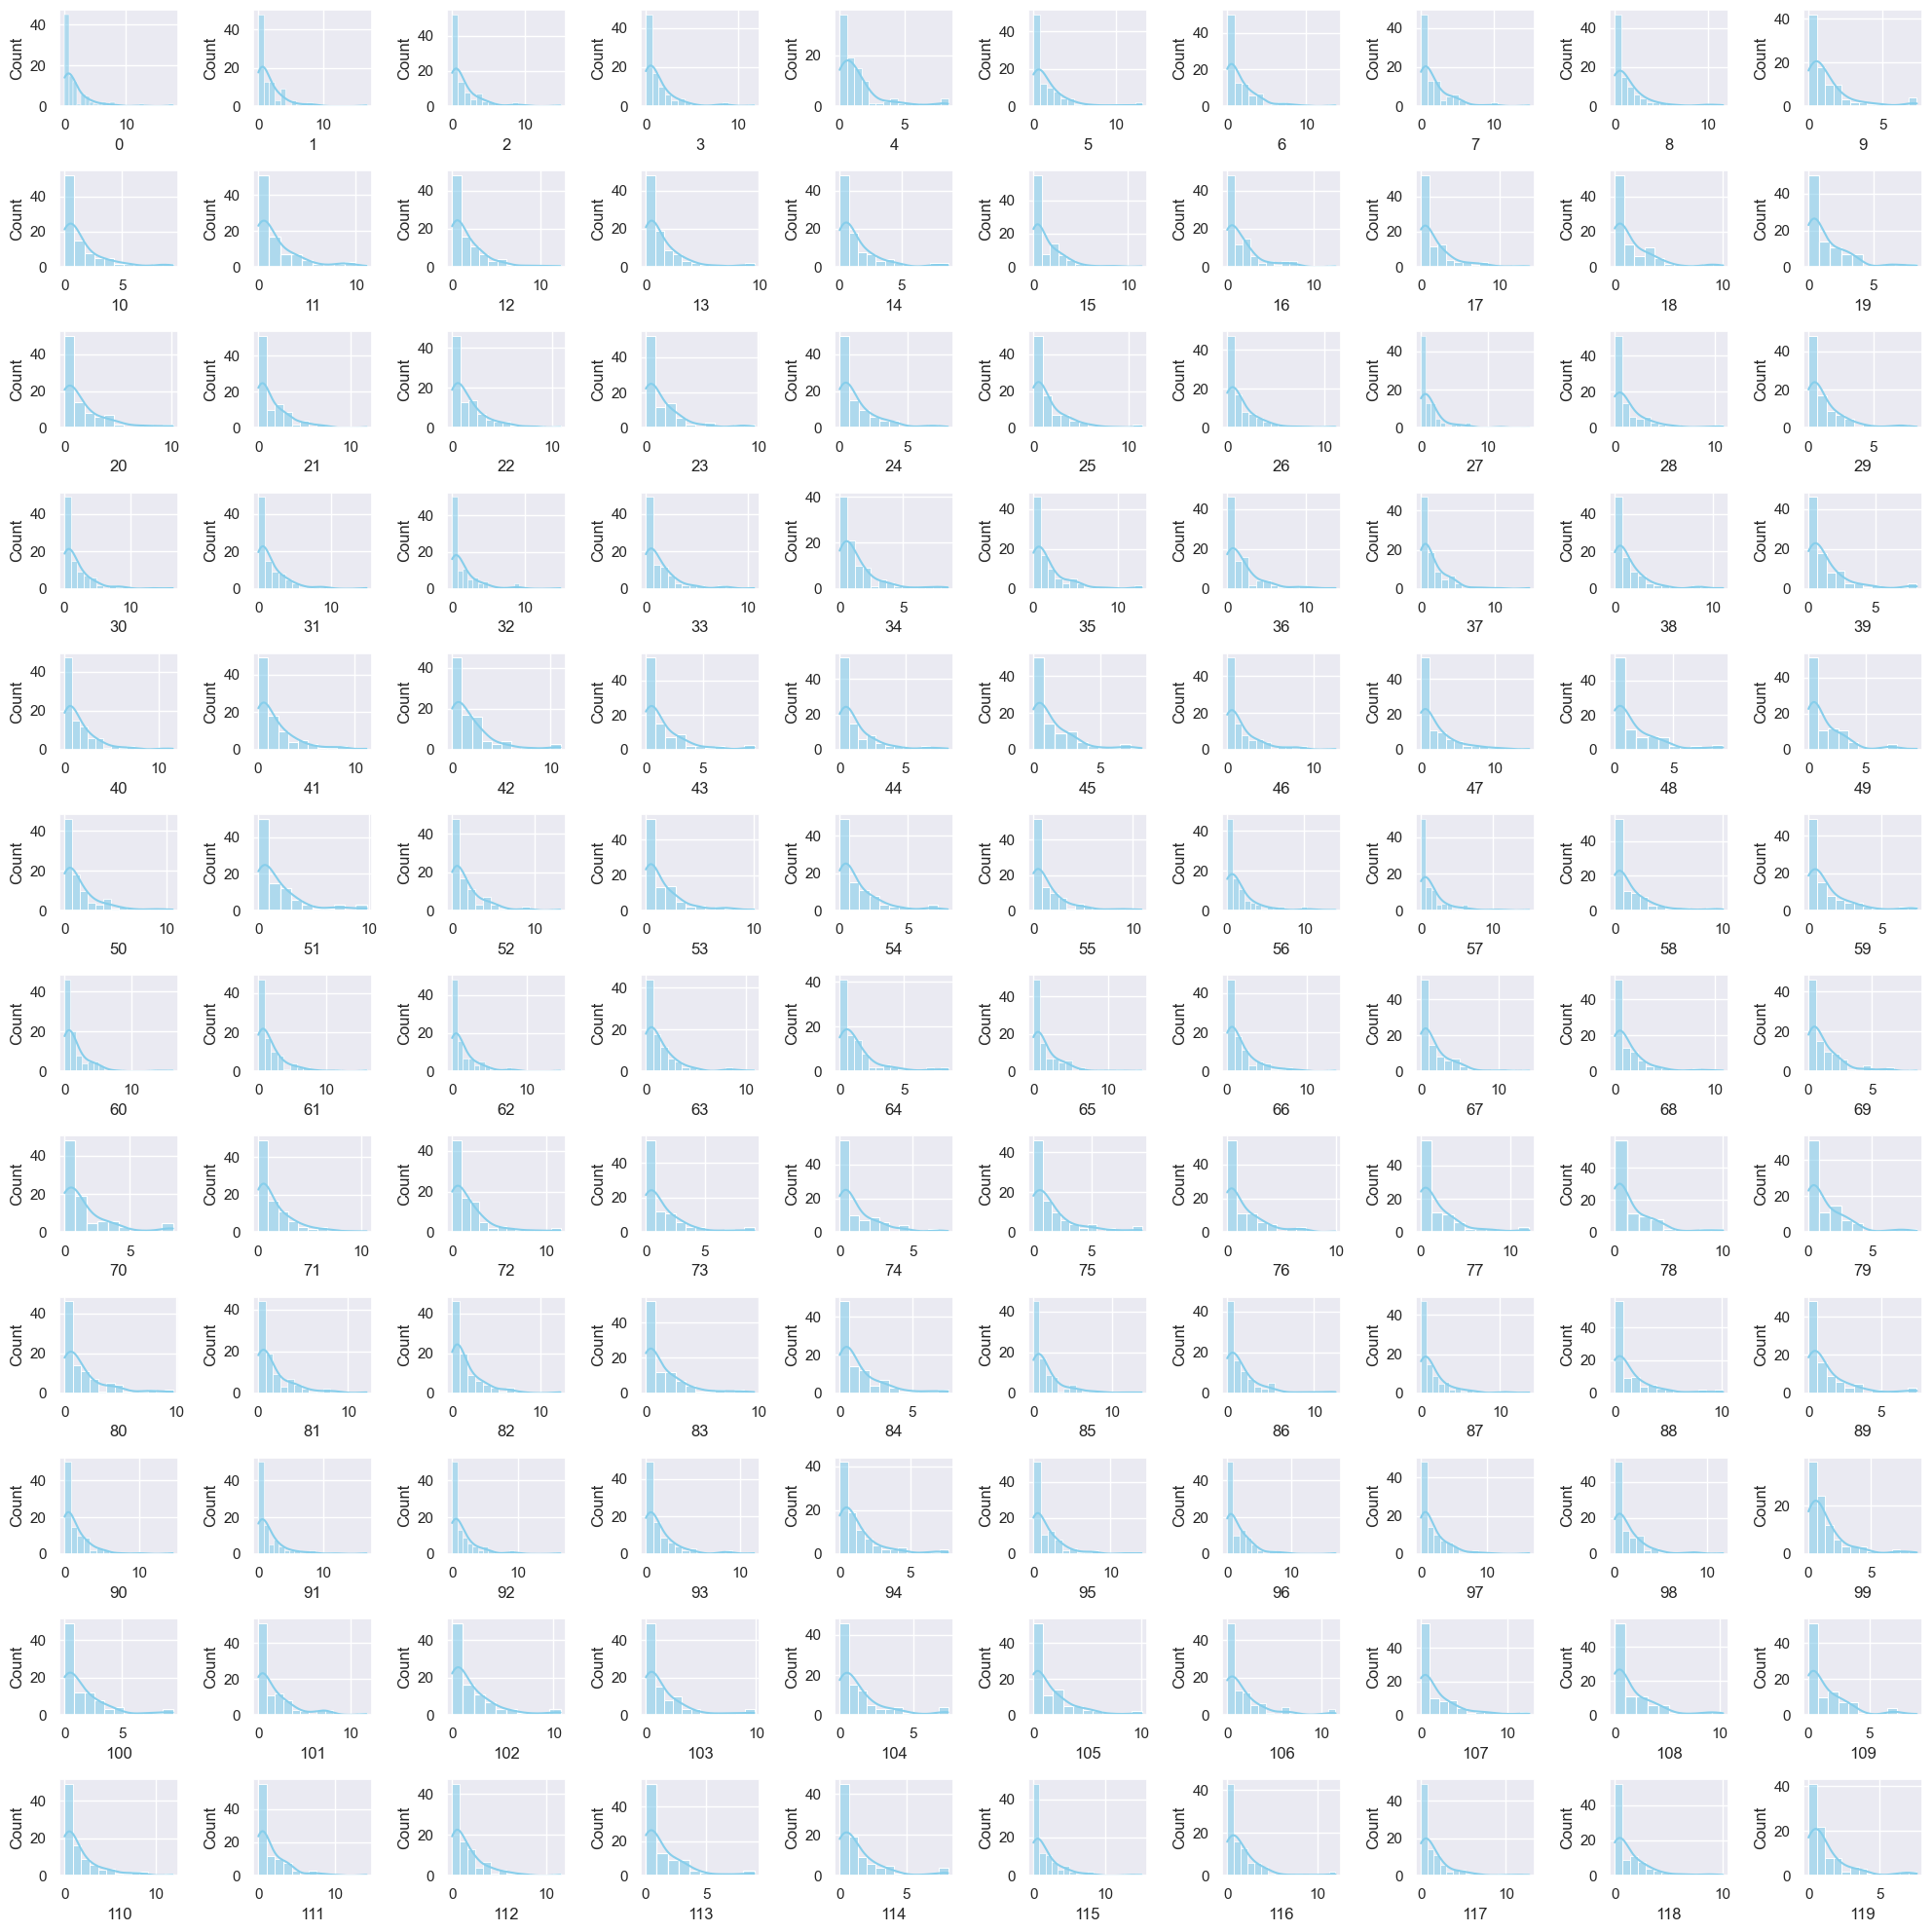

In [34]:
plot_distrib(visp)

In [35]:
visal.describe()

0          1          2          3          4          5    \
count  89.000000  89.000000  89.000000  89.000000  89.000000  89.000000   
mean    1.712222   1.480165   1.177253   1.104792   1.062830   1.784453   
std     2.430960   2.215062   1.604357   1.291910   1.086536   2.548542   
min     0.000000   0.020408   0.000000   0.000000   0.000000   0.000000   
25%     0.285714   0.285714   0.285714   0.306122   0.265306   0.224490   
50%     0.877551   0.571429   0.673469   0.673469   0.755102   0.775510   
75%     2.122449   1.632653   1.346939   1.489796   1.510204   2.326531   
max    13.367347  12.489796  10.510204   7.857143   4.959184  13.571429   

             6          7          8          9    ...        110        111  \
count  89.000000  89.000000  89.000000  89.000000  ...  89.000000  89.000000   
mean    1.552135   1.350837   1.174501   1.062600  ...   1.902247   1.898876   
std     2.305960   1.700698   1.387687   1.117669  ...   2.651373   2.588228   
min     0.000000   0.000000   0.000000   0.000000  ...   0.000000   0.000000   
25%     0.180000   0.285714   0.306122   0.265306  ...   0.200000   0.204082   
50%     0.580000   0.734694   0.693878   0.714286  ...   1.000000   0.714286   
75%     1.920000   1.755102   1.653061   1.285714  ...   2.620000   2.673469   
max    12.060000  10.061224   8.224490   5.469388  ...  15.680000  13.265306   

             112        113        114        115        116        117  \
count  89.000000  89.000000  89.000000  89.000000  89.000000  89.000000   
mean    1.603761   1.205667   1.107773   1.858519   1.669710   1.205290   
std     1.843663   1.331196   1.132223   2.332524   2.214076   1.589094   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     0.346939   0.239130   0.244898   0.285714   0.208333   0.250000   
50%     0.857143   0.804348   0.816327   0.836735   0.812500   0.687500   
75%     2.224490   1.956522   1.591837   2.836735   2.354167   1.583333   
max     8.755102   6.260870   5.530612  11.755102  13.020833  10.333333   

             118        119  
count  89.000000  89.000000  
mean    1.106168   1.042421  
std     1.273372   1.036420  
min     0.000000   0.000000  
25%     0.306122   0.346939  
50%     0.734694   0.755102  
75%     1.469388   1.408163  
max     8.000000   4.775510  

[8 rows x 120 columns]

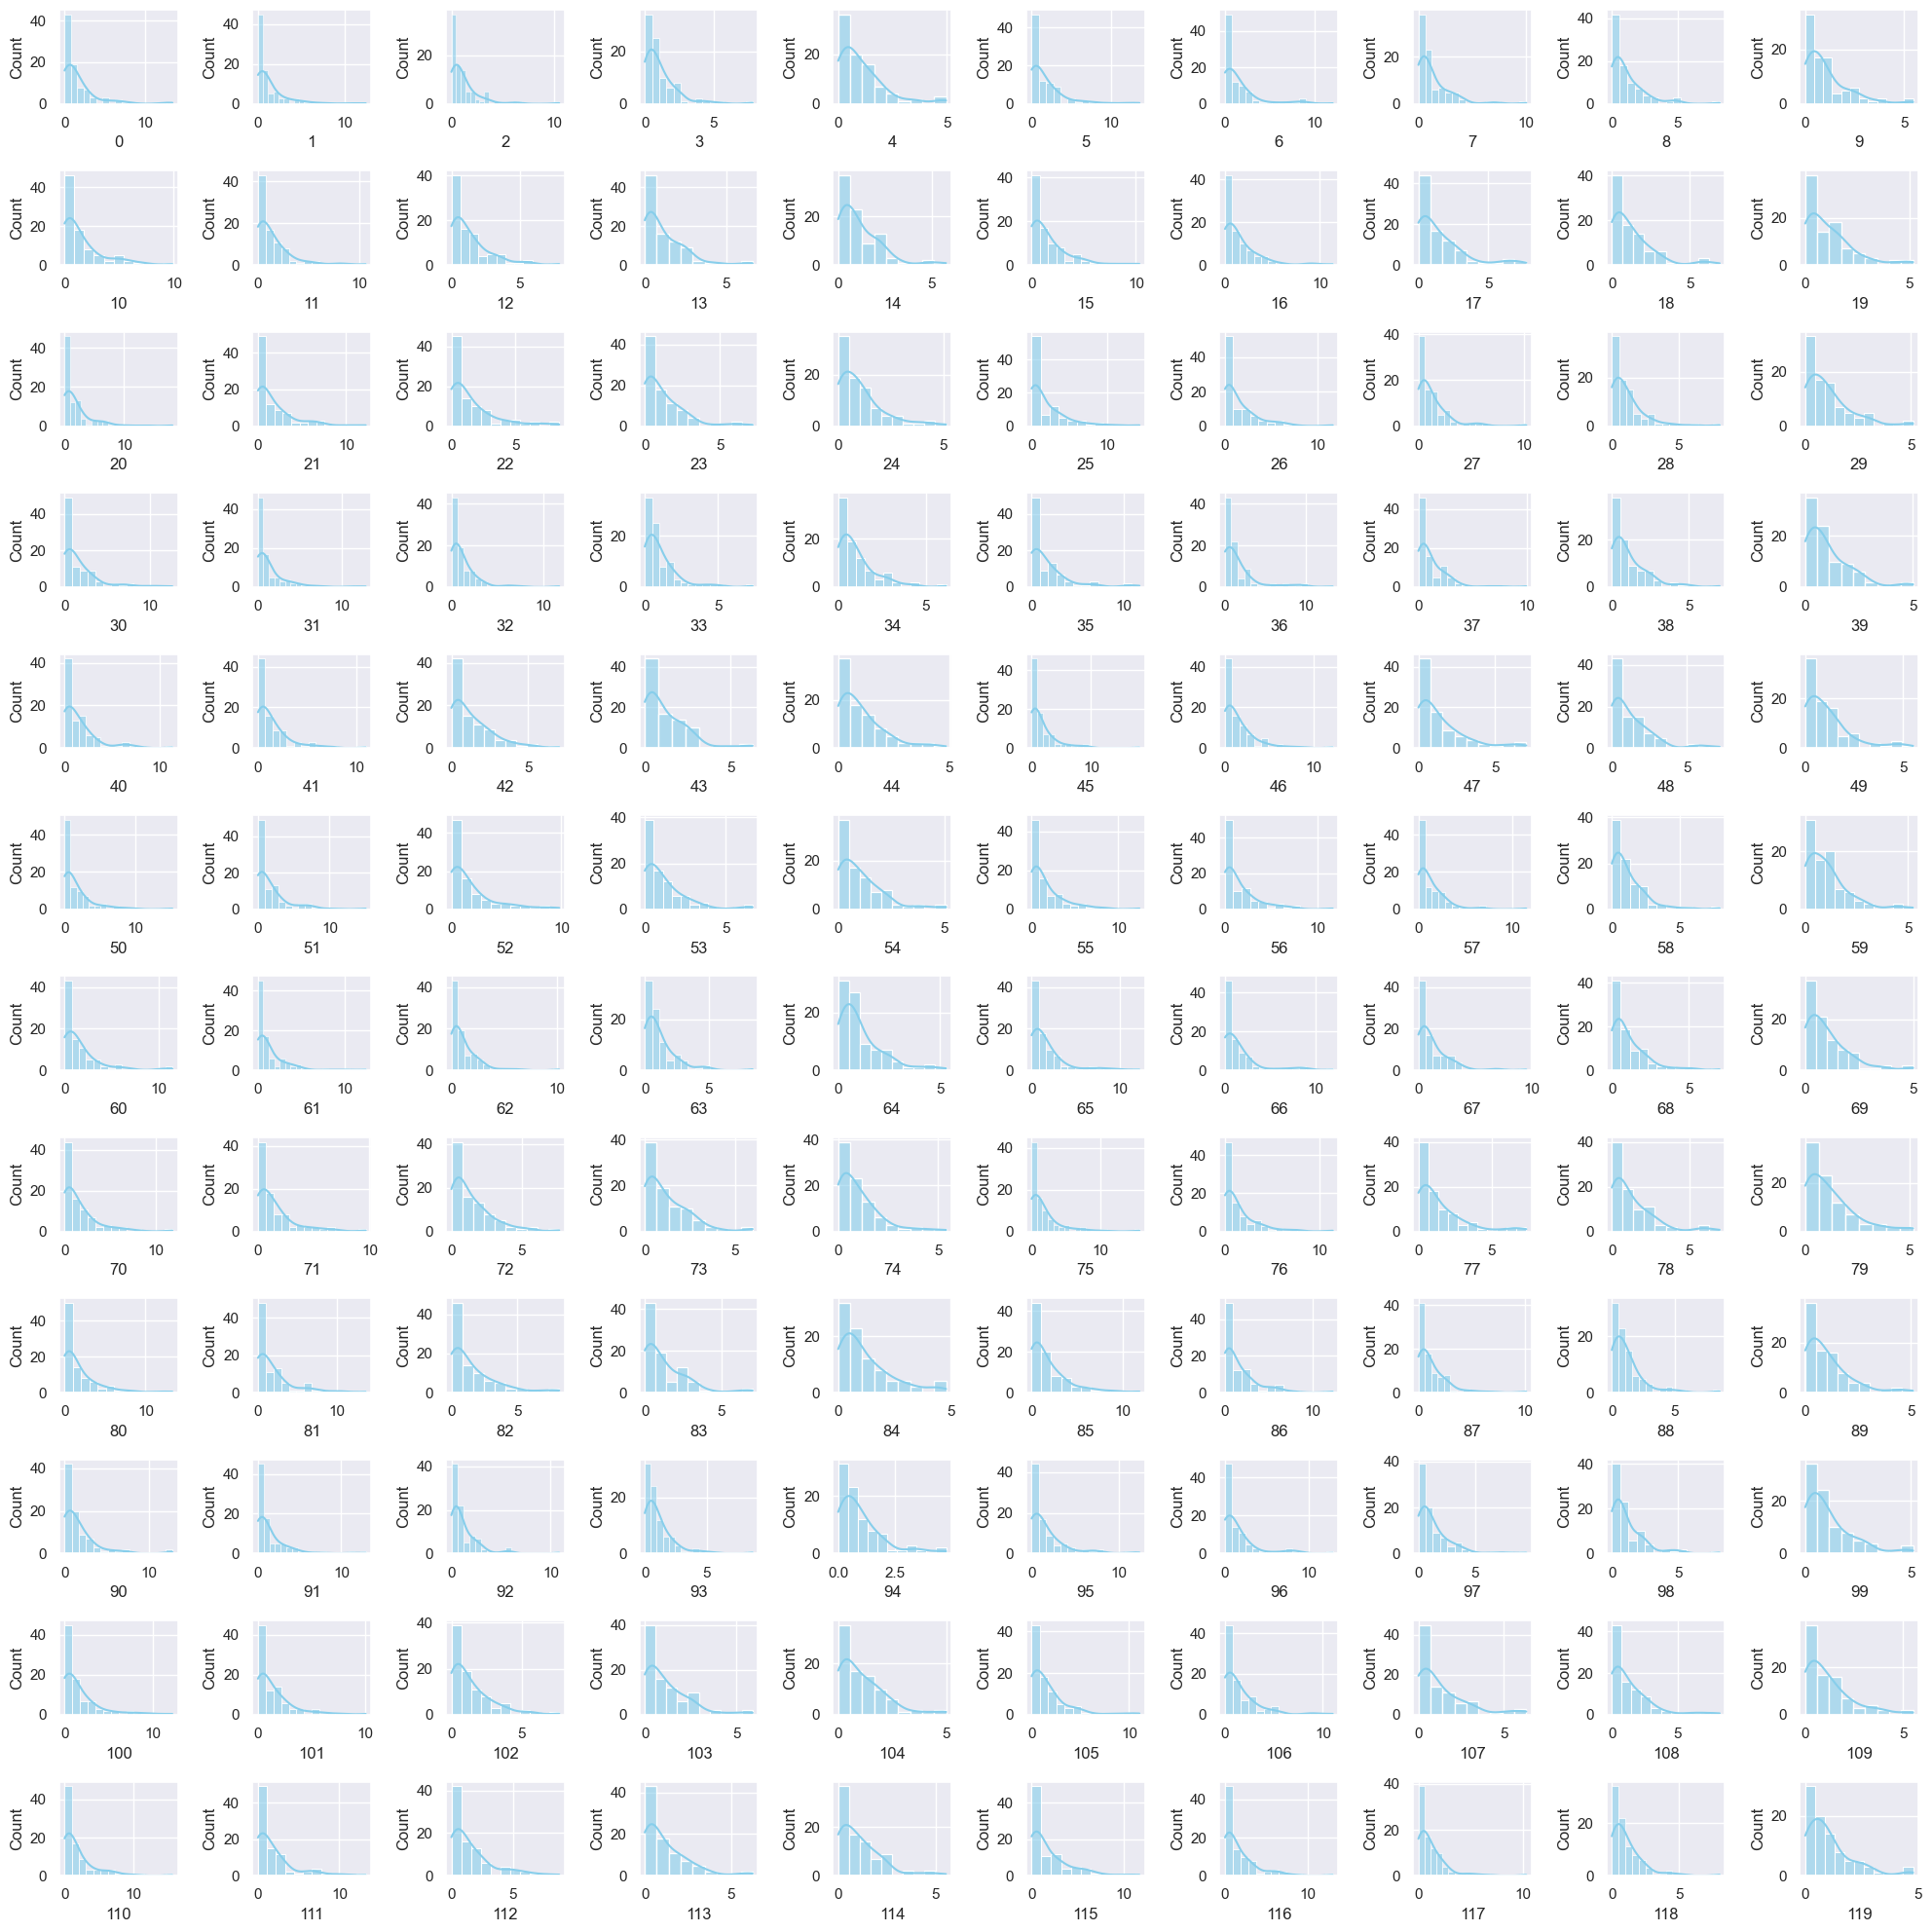

In [36]:
plot_distrib(visal)

In [37]:
visrl.describe()

0          1          2          3          4          5    \
count  47.000000  47.000000  47.000000  47.000000  47.000000  47.000000   
mean    1.891880   1.550152   1.468085   1.456795   1.449414   1.834998   
std     1.927436   1.720959   1.725978   1.611051   1.446181   1.826362   
min     0.061224   0.061224   0.040816   0.000000   0.020408   0.000000   
25%     0.336735   0.265306   0.295918   0.306122   0.438776   0.397959   
50%     1.326531   0.755102   0.693878   0.795918   0.836735   1.142857   
75%     2.806122   2.265306   1.775510   1.989796   2.112245   2.346939   
max     9.102041   5.612245   6.265306   6.836735   6.387755   7.979592   

             6          7          8          9    ...        110        111  \
count  47.000000  47.000000  47.000000  47.000000  ...  47.000000  47.000000   
mean    1.622979   1.454624   1.445072   1.439427  ...   1.917021   1.694312   
std     1.790035   1.672288   1.564468   1.376546  ...   1.906739   1.911751   
min     0.020000   0.040816   0.000000   0.061224  ...   0.040000   0.020408   
25%     0.330000   0.275510   0.265306   0.397959  ...   0.350000   0.408163   
50%     0.780000   0.571429   0.877551   1.020408  ...   1.260000   1.142857   
75%     2.580000   2.234694   2.112245   2.397959  ...   2.960000   1.867347   
max     6.600000   6.285714   6.367347   5.857143  ...   7.340000   9.571429   

             112        113        114        115        116        117  \
count  47.000000  47.000000  47.000000  47.000000  47.000000  47.000000   
mean    1.652627   1.453284   1.488059   1.990881   1.686613   1.526596   
std     1.628930   1.617707   1.530274   2.179946   1.787116   1.752364   
min     0.020408   0.000000   0.040816   0.040816   0.020833   0.000000   
25%     0.377551   0.293478   0.377551   0.336735   0.364583   0.239583   
50%     1.122449   0.869565   0.918367   1.000000   1.041667   0.895833   
75%     2.040816   2.054348   2.142857   2.887755   2.114583   1.947917   
max     6.979592   7.282609   7.142857   8.489796   7.250000   7.791667   

             118        119  
count  47.000000  47.000000  
mean    1.468085   1.468085  
std     1.600065   1.381932  
min     0.040816   0.061224  
25%     0.316327   0.377551  
50%     0.918367   0.857143  
75%     2.183673   2.295918  
max     6.857143   5.489796  

[8 rows x 120 columns]

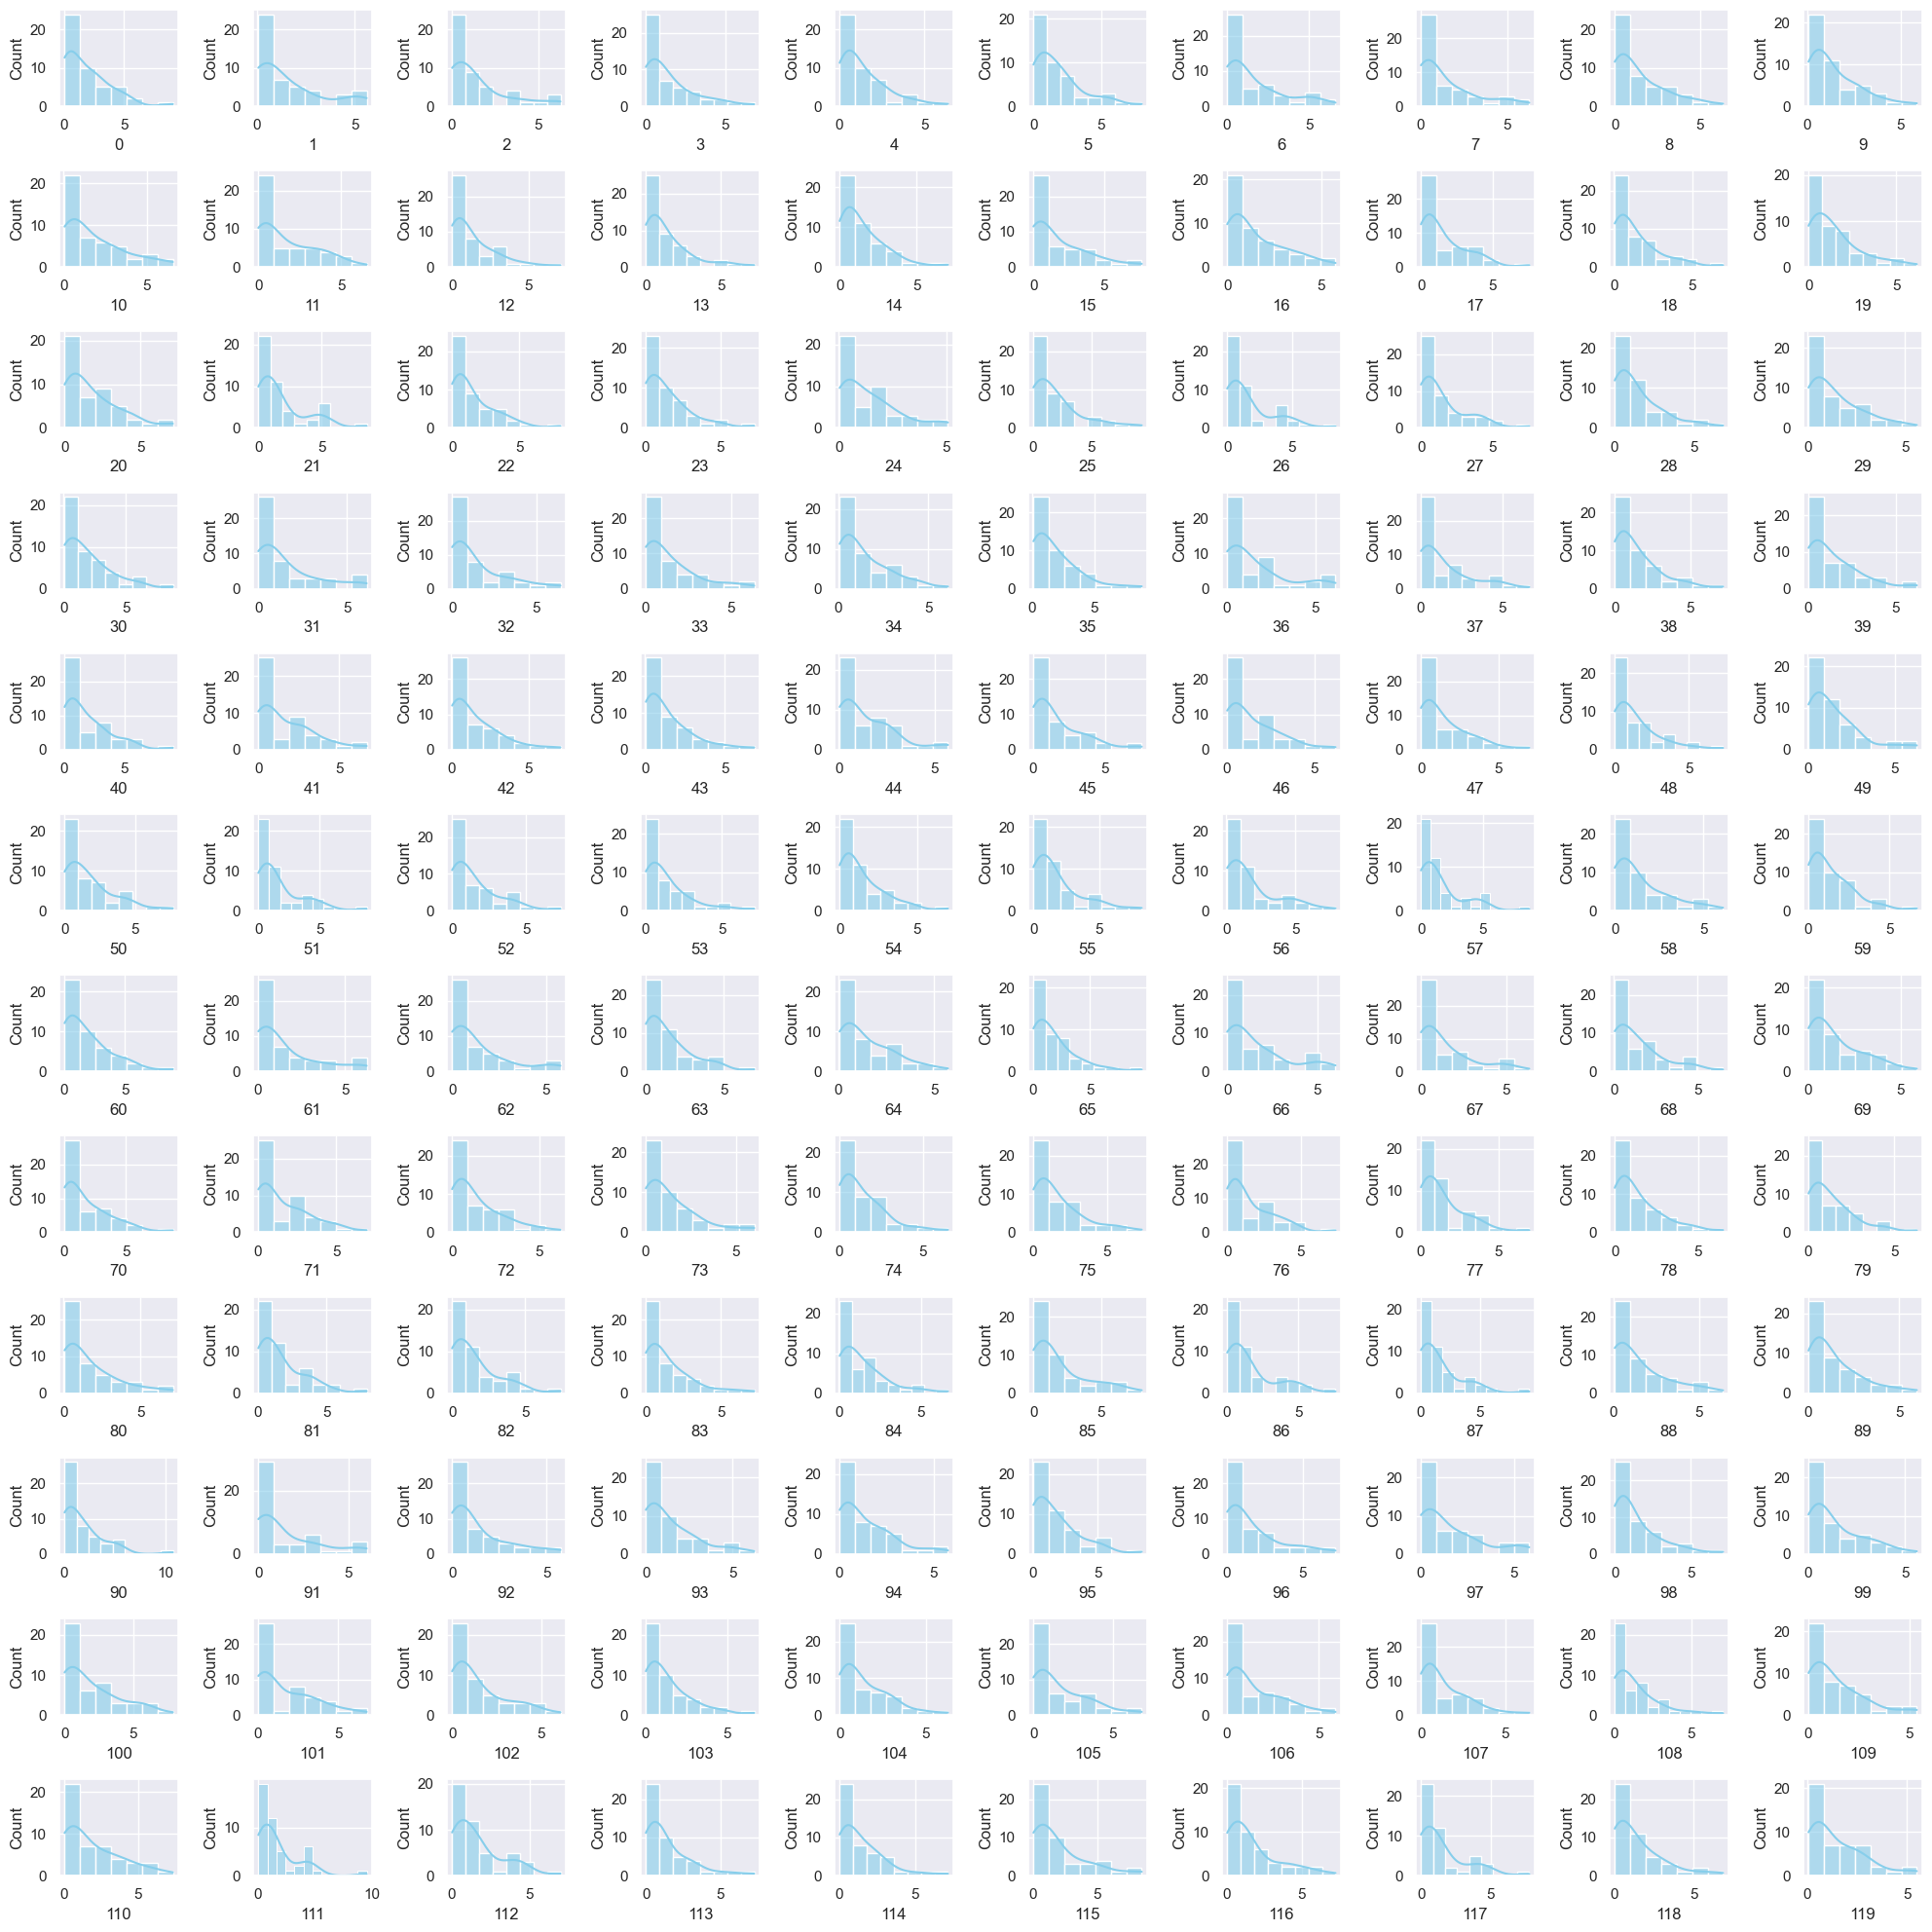

In [38]:
plot_distrib(visrl)

In [39]:
visl.describe()

0          1          2          3          4          5    \
count  78.000000  78.000000  78.000000  78.000000  78.000000  78.000000   
mean    1.204605   1.409471   1.408163   1.277080   1.079801   1.182889   
std     1.878136   1.938175   1.883336   1.631647   1.305361   1.826403   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.020408   
25%     0.250000   0.229592   0.198980   0.275510   0.244898   0.183673   
50%     0.622449   0.704082   0.734694   0.744898   0.653061   0.591837   
75%     1.448980   1.586735   1.622449   1.530612   1.260204   1.295918   
max    12.183673   9.693878  10.224490   8.061224   6.489796  12.428571   

             6          7          8          9    ...        110        111  \
count  78.000000  78.000000  78.000000  78.000000  ...  78.000000  78.000000   
mean    1.295897   1.521978   1.420722   0.980115  ...   1.239744   1.154108   
std     1.789224   1.960766   1.918729   1.173360  ...   1.790151   1.715884   
min     0.020000   0.020408   0.000000   0.020408  ...   0.000000   0.000000   
25%     0.265000   0.270408   0.290816   0.265306  ...   0.180000   0.224490   
50%     0.810000   0.908163   0.755102   0.510204  ...   0.580000   0.459184   
75%     1.615000   1.933673   1.545918   1.352041  ...   1.505000   1.270408   
max     9.460000  10.244898   9.285714   6.510204  ...  10.920000   8.244898   

             112        113        114        115        116        117  \
count  78.000000  78.000000  78.000000  78.000000  78.000000  78.000000   
mean    1.137101   1.182274   1.006018   1.331763   1.331998   1.266026   
std     1.679193   1.769693   1.324472   1.791792   1.790327   1.600615   
min     0.000000   0.021739   0.000000   0.000000   0.000000   0.020833   
25%     0.229592   0.239130   0.224490   0.306122   0.250000   0.312500   
50%     0.530612   0.597826   0.459184   0.632653   0.593750   0.625000   
75%     1.382653   1.418478   1.362245   1.714286   1.557292   1.593750   
max    11.183673  10.739130   7.204082  10.816327   8.187500   8.083333   

             118        119  
count  78.000000  78.000000  
mean    1.355311   1.027473  
std     1.950691   1.169065  
min     0.000000   0.020408  
25%     0.270408   0.229592  
50%     0.693878   0.622449  
75%     1.484694   1.474490  
max     9.897959   5.306122  

[8 rows x 120 columns]

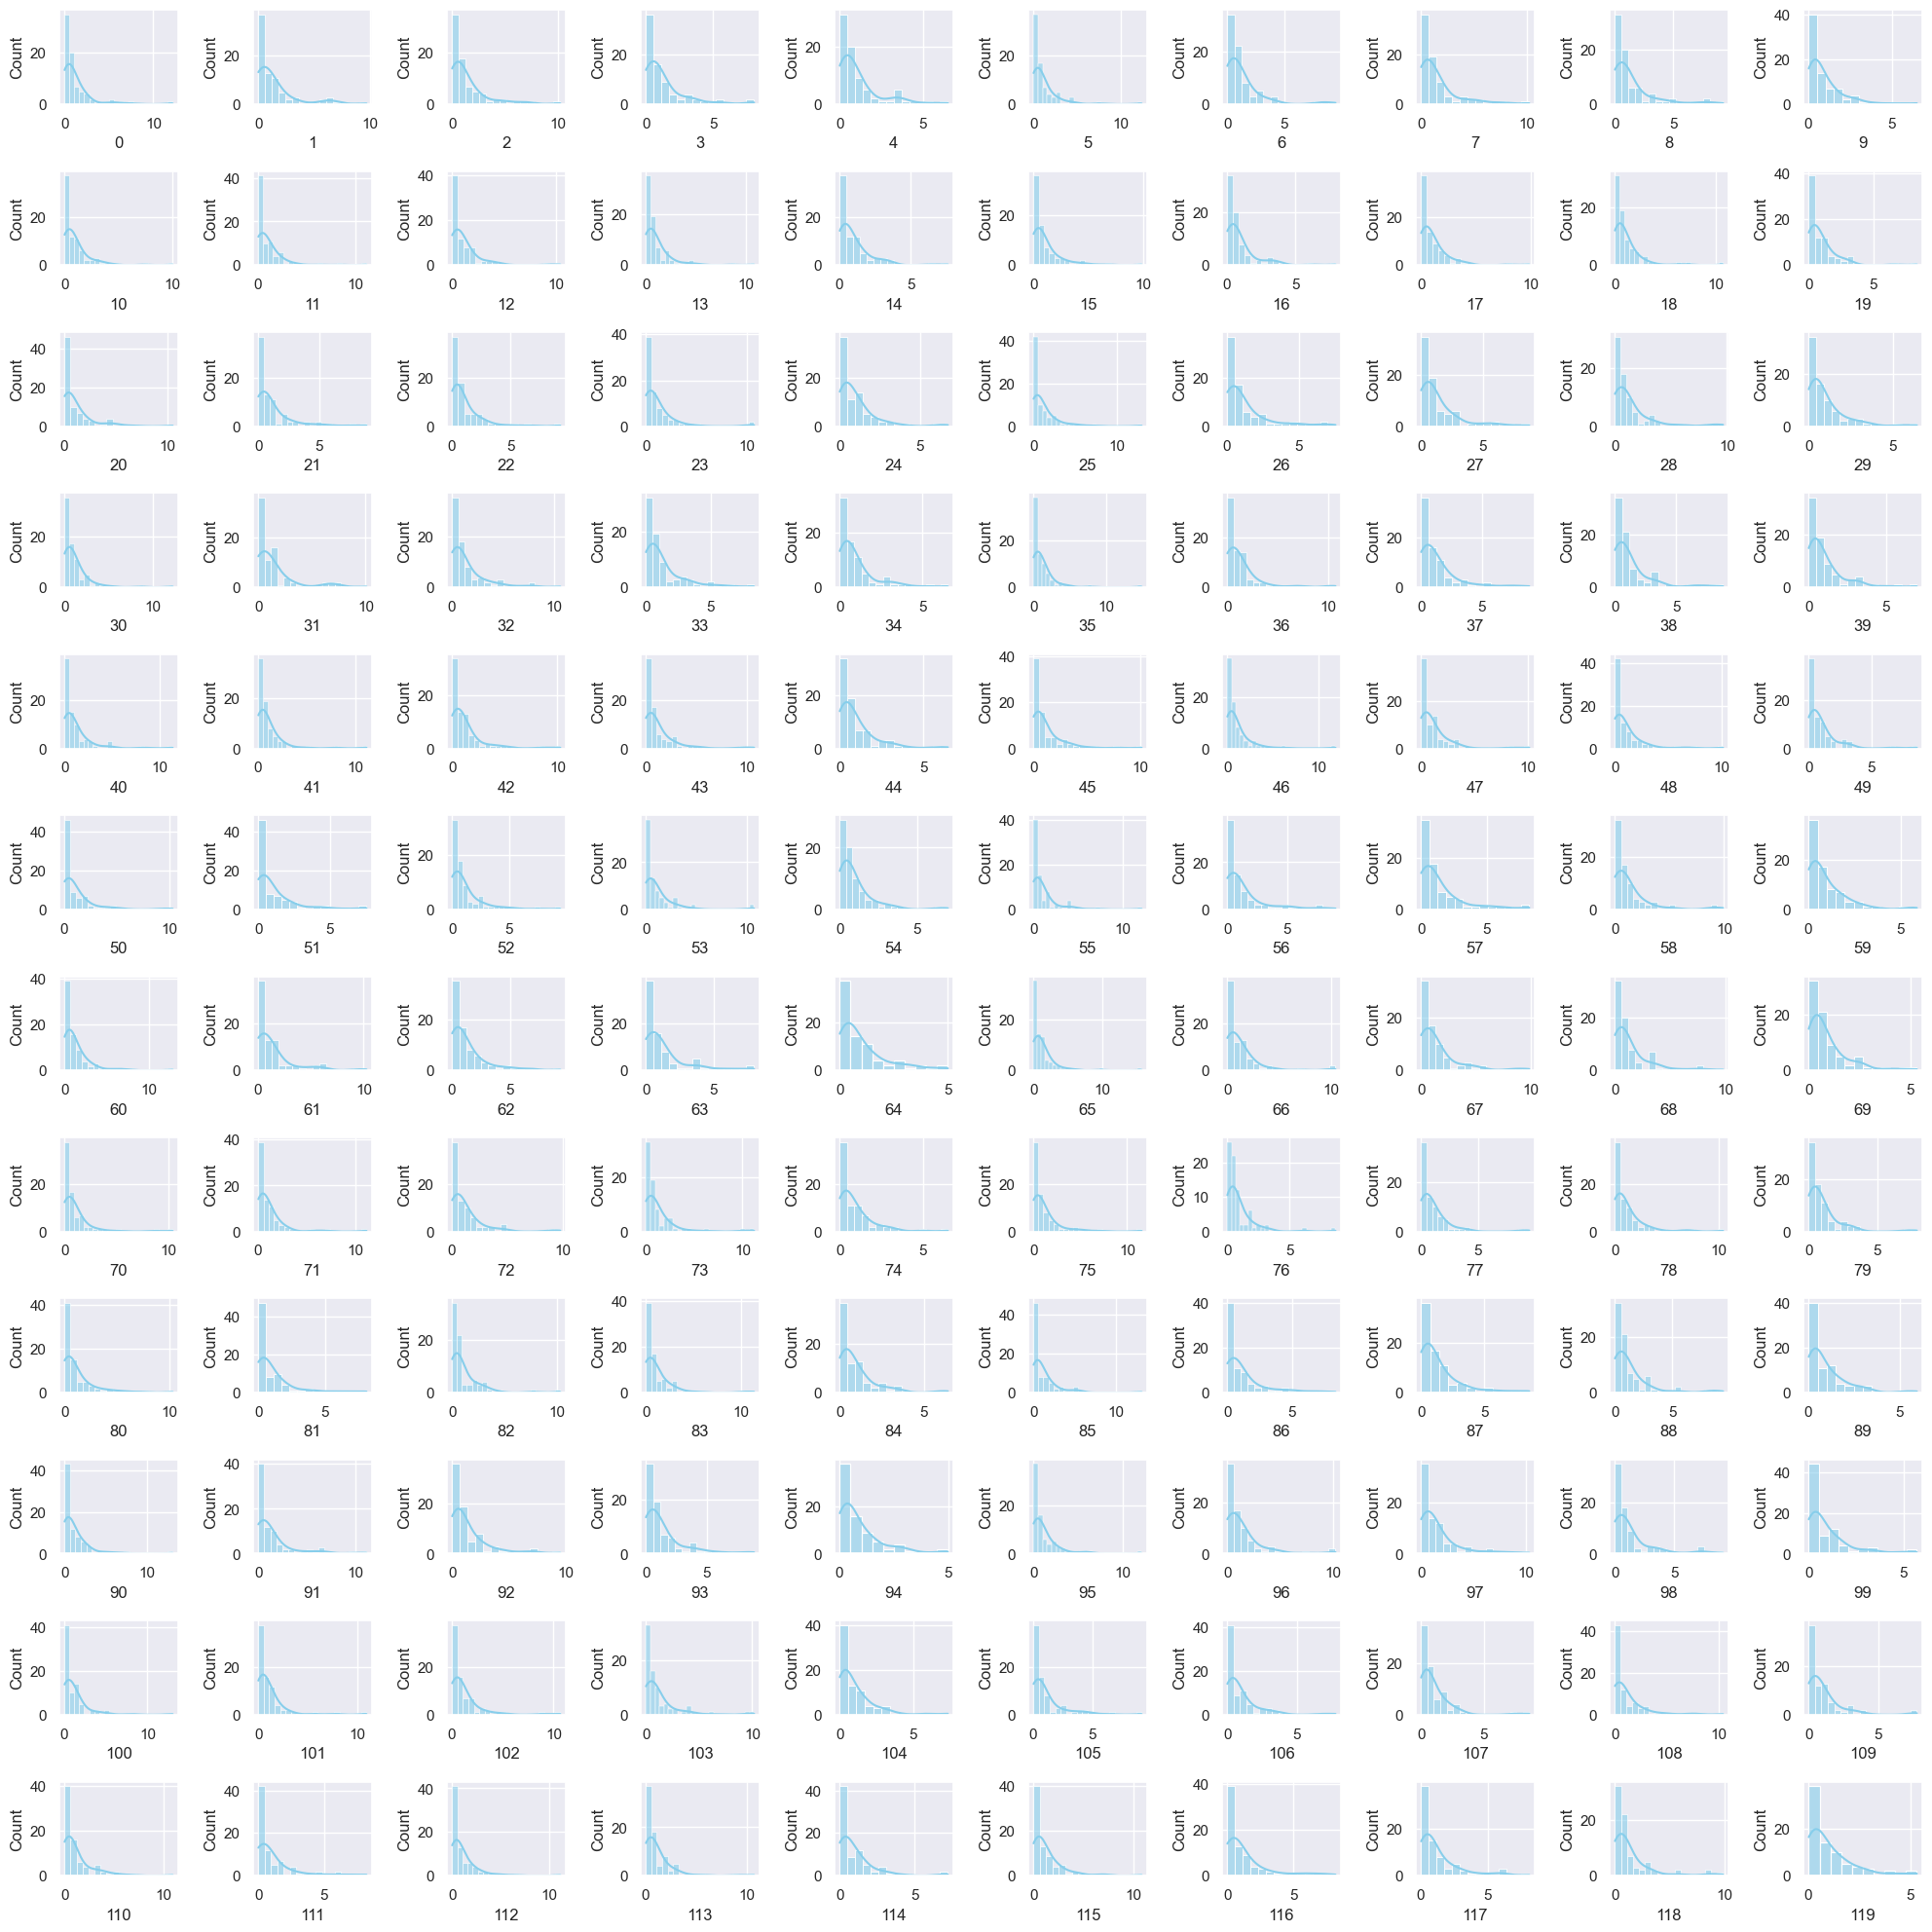

In [40]:
plot_distrib(visl)

We see that for each area many neurons exhibit an average spike count close to 0, while some display notably higher counts.

For example, in VISp certain neurons register averages above 17 counts, which is quite high compared to the typical trend around 0. We need to understand whether this pattern constitutes normal behavior. Are these neurons particularly responsive to specific static grating stimuli, remaining inactive for others, or are they always active showing high counts for each grating presentation?

Moreover, we need to understand if there are neurons always inactive for all stimuli presentations, displaying very low counts for every type of static grating.

We start from the second task, taking as a threshold for inactivity a value of counts below 0.5 for every displayed image. We choose empirically a threshold of 0.5 since we require that at least in half of the trials each neuron has one spike.

In [41]:
num_rows = visam.shape[0]

visam_zero_counts = []

for i in range(num_rows):
    count = 0
    for j in range(120):
        if visam.iloc[i, j] <= 0.5:
            count += 1
    if count == 120:
        visam_zero_counts.append(visam.index[i])

print(len(visam_zero_counts), 'neurons of VISam out of', num_rows, 'show spike counts lower than 0.5 for every static grating presentation')


17 neurons of VISam out of 135 show spike counts lower than 0.5 for every static grating presentation


In [42]:
num_rows = visp.shape[0]

visp_zero_counts = []

for i in range(num_rows):
    count = 0
    for j in range(120):
        if visp.iloc[i, j] <= 0.5:
            count += 1
    if count == 120:
        visp_zero_counts.append(visp.index[i])

print(len(visp_zero_counts), 'neurons of VISp out of', num_rows, 'show spike counts lower than 0.5 for every static grating presentation')

5 neurons of VISp out of 94 show spike counts lower than 0.5 for every static grating presentation


In [43]:
num_rows = visal.shape[0]

visal_zero_counts = []

for i in range(num_rows):
    count = 0
    for j in range(120):
        if visal.iloc[i, j] <= 0.5:
            count += 1
    if count == 120:
        visal_zero_counts.append(visal.index[i])

print(len(visal_zero_counts), 'neurons of VISal out of', num_rows, 'show spike counts lower than 0.5 for every static grating presentation')

9 neurons of VISal out of 89 show spike counts lower than 0.5 for every static grating presentation


In [44]:
num_rows = visrl.shape[0]

visrl_zero_counts = []

for i in range(num_rows):
    count = 0
    for j in range(120):
        if visrl.iloc[i, j] <= 0.5:
            count += 1
    if count == 120:
        visrl_zero_counts.append(visrl.index[i])

print(len(visrl_zero_counts), 'neurons of VISrl out of', num_rows, 'show spike counts lower than 0.5 for every static grating presentation')

4 neurons of VISrl out of 47 show spike counts lower than 0.5 for every static grating presentation


In [45]:
num_rows = visl.shape[0]

visl_zero_counts = []

for i in range(num_rows):
    count = 0
    for j in range(120):
        if visl.iloc[i, j] <= 0.5:
            count += 1
    if count == 120:
        visl_zero_counts.append(visl.index[i])

print(len(visl_zero_counts), 'neurons of VISl out of', num_rows, 'show spike counts lower than 0.5 for every static grating presentation')

8 neurons of VISl out of 78 show spike counts lower than 0.5 for every static grating presentation


All of these neurons are probably dead, because they show very low responses to all stimuli. We should remove them from our datasets.

In [46]:
for x in visam_zero_counts:
    visam = visam.drop(x)

for x in visp_zero_counts:
    visp = visp.drop(x)

for x in visal_zero_counts:
    visal = visal.drop(x)

for x in visrl_zero_counts:
    visrl = visrl.drop(x)

for x in visl_zero_counts:
    visl = visl.drop(x)

We repeat the same analysis for too high counts: let's see if there are neurons that are always very active no matter which stimulus is presented.

We employ as threshold for each grating the value of the interquartile range (computed over the columns) multiplied by 1.5: if a neuron responds to every grating with an average count that is above the specific threshold computed for that stimulus, then it is considered an outlier.

In [47]:
quantiles = visam.quantile([0.25, 0.75])
iqr = quantiles.loc[0.75] - quantiles.loc[0.25]
thresh_visam = 1.5*iqr
print('Threshold VISam:', thresh_visam)

quantiles = visp.quantile([0.25, 0.75])
iqr = quantiles.loc[0.75] - quantiles.loc[0.25]
thresh_visp = 1.5*iqr
print('Threshold VISp', thresh_visp)

quantiles = visal.quantile([0.25, 0.75])
iqr = quantiles.loc[0.75] - quantiles.loc[0.25]
thresh_visal = 1.5*iqr
print('Threshold VISal:', thresh_visal)

quantiles = visrl.quantile([0.25, 0.75])
iqr = quantiles.loc[0.75] - quantiles.loc[0.25]
thresh_visrl = 1.5*iqr
print('Threshold VISrl:', thresh_visrl)

quantiles = visl.quantile([0.25, 0.75])
iqr = quantiles.loc[0.75] - quantiles.loc[0.25]
thresh_visl = 1.5*iqr
print('Threshold VISl:', thresh_visl)

Threshold VISam: 0      2.931122
1      3.719388
2      4.079082
3      3.153061
4      3.252551
         ...   
115    3.015306
116    4.000000
117    3.500000
118    3.283163
119    2.938776
Length: 120, dtype: float64
Threshold VISp 0      2.234694
1      2.969388
2      2.877551
3      2.479592
4      1.959184
         ...   
115    3.459184
116    2.843750
117    2.687500
118    2.785714
119    2.234694
Length: 120, dtype: float64
Threshold VISal: 0      2.892857
1      2.563776
2      1.852041
3      1.821429
4      1.698980
         ...   
115    3.841837
116    3.460938
117    2.062500
118    1.844388
119    1.561224
Length: 120, dtype: float64
Threshold VISrl: 0      3.795918
1      3.045918
2      2.387755
3      2.724490
4      2.862245
         ...   
115    3.933673
116    2.546875
117    2.734375
118    3.153061
119    2.862245
Length: 120, dtype: float64
Threshold VISl: 0      1.875000
1      2.089286
2      2.372449
3      1.936224
4      1.660714
         ...   
115   

/var/folders/gd/b2d40bms7s3f8y4f31x7pk1r0000gn/T/ipykernel_55056/3035560584.py:1: FutureWarning:

The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

/var/folders/gd/b2d40bms7s3f8y4f31x7pk1r0000gn/T/ipykernel_55056/3035560584.py:6: FutureWarning:

The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

/var/folders/gd/b2d40bms7s3f8y4f31x7pk1r0000gn/T/ipykernel_55056/3035560584.py:11: FutureWarning:

The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

/var/folders/gd/b2d40bms7s3f8y4f31x7pk1r0000gn/T/ipykernel_55056/3035560584.py:16: F

In [48]:
num_rows = visam.shape[0]

visam_high_counts = []

for i in range(num_rows):
    count = 0
    for j in range(120):
        if visam.iloc[i, j] > thresh_visam[j]:
            count += 1
    if count == 120:
        visam_high_counts.append(visam.index[i])

print(len(visam_high_counts), 'neurons of VISam out of', num_rows, 'show always spike counts for every static grating presentation')

10 neurons of VISam out of 118 show always spike counts for every static grating presentation


In [49]:
num_rows = visp.shape[0]

visp_high_counts = []

for i in range(num_rows):
    count = 0
    for j in range(120):
        if visp.iloc[i, j] > thresh_visp[j]:
            count += 1
    if count == 120:
        visp_high_counts.append(visp.index[i])

print(len(visp_high_counts), 'neurons of VISp out of', num_rows, 'show always spike counts for every static grating presentation')

4 neurons of VISp out of 89 show always spike counts for every static grating presentation


In [50]:
num_rows = visal.shape[0]

visal_high_counts = []

for i in range(num_rows):
    count = 0
    for j in range(120):
        if visal.iloc[i, j] > thresh_visal[j]:
            count += 1
    if count == 120:
        visal_high_counts.append(visal.index[i])

print(len(visal_high_counts), 'neurons of VISal out ofout of', num_rows, 'show always spike counts for every static grating presentation')

1 neurons of VISal out ofout of 80 show always spike counts for every static grating presentation


In [51]:
num_rows = visrl.shape[0]

visrl_high_counts = []

for i in range(num_rows):
    count = 0
    for j in range(120):
        if visrl.iloc[i, j] > thresh_visrl[j]:
            count += 1
    if count == 120:
        visrl_high_counts.append(visrl.index[i])

print(len(visrl_high_counts), 'neurons of VISrl out of', num_rows, 'show always spike counts for every static grating presentation')

2 neurons of VISrl out of 43 show always spike counts for every static grating presentation


In [52]:
num_rows = visl.shape[0]

visl_high_counts = []

for i in range(num_rows):
    count = 0
    for j in range(120):
        if visl.iloc[i, j] > thresh_visl[j]:
            count += 1
    if count == 120:
        visl_high_counts.append(visl.index[i])

print(len(visl_high_counts), 'neurons of VISl out of', num_rows, 'show always spike counts for every static grating presentation')

4 neurons of VISl out of 70 show always spike counts for every static grating presentation


In [53]:
for x in visam_high_counts:
    visam = visam.drop(x)

for x in visp_high_counts:
    visp = visp.drop(x)

for x in visal_high_counts:
    visal = visal.drop(x)

for x in visrl_high_counts:
    visrl = visrl.drop(x)

for x in visl_high_counts:
    visl = visl.drop(x)

In [54]:
region_ids_VISp = oursession.units[oursession.units["ecephys_structure_acronym"]=='VISp'].index.values
elements_to_remove_visp = np.array(visp_zero_counts + visp_high_counts)
mask = np.isin(region_ids_VISp, elements_to_remove_visp, invert=True)
region_ids_VISp = region_ids_VISp[mask]

region_ids_VISl = oursession.units[oursession.units["ecephys_structure_acronym"]=='VISl'].index.values 
elements_to_remove_visl = np.array(visl_zero_counts + visl_high_counts)
mask = np.isin(region_ids_VISl, elements_to_remove_visl, invert=True)
region_ids_VISl = region_ids_VISl[mask]

region_ids_VISal = oursession.units[oursession.units["ecephys_structure_acronym"]=='VISal'].index.values
elements_to_remove_visal = np.array(visal_zero_counts + visal_high_counts)
mask = np.isin(region_ids_VISal, elements_to_remove_visal, invert=True)
region_ids_VISal = region_ids_VISal[mask]

region_ids_VISpm = oursession.units[oursession.units["ecephys_structure_acronym"]=='VISpm'].index.values    # empty

region_ids_VISam = oursession.units[oursession.units["ecephys_structure_acronym"]=='VISam'].index.values
elements_to_remove_visam = np.array(visam_zero_counts + visam_high_counts)
mask = np.isin(region_ids_VISam, elements_to_remove_visam, invert=True)
region_ids_VISam = region_ids_VISam[mask]

region_ids_VISrl = oursession.units[oursession.units["ecephys_structure_acronym"]=='VISrl'].index.values
elements_to_remove_visrl = np.array(visrl_zero_counts + visrl_high_counts)
mask = np.isin(region_ids_VISrl, elements_to_remove_visrl, invert=True)
region_ids_VISrl = region_ids_VISrl[mask]

### Pairwise Linear Correlation

In [55]:
from f import spike_count_per_trial_by_unit, spike_count_by_unit 

In [56]:
def compute_corr(unit_ids, parameter_key, parameters_dict = parameters_dict, spikes = spikes):
    """
    Given brain cortex region and parameter_key,
    computes average of pairwise linear correlation 
    and its standard deviation.
    """
    if parameter_key is not None:
        data = spike_count_per_trial_by_unit(parameters_dict, spikes, unit_ids, parameter_key)
    else:
        data = spike_count_by_unit(spikes, unit_ids) 
    df = pd.DataFrame(data)
    corr = df.corr()

    corr_values = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    return corr, corr_values.mean().mean(), corr_values.stack().std()

Average correlation is: 0.024477449481621547
Standard deviation of correlation is: 0.18017865833650554


<Axes: title={'center': 'correlation of visam cells for stimuli (0.5, 150.0, 0.02)'}>

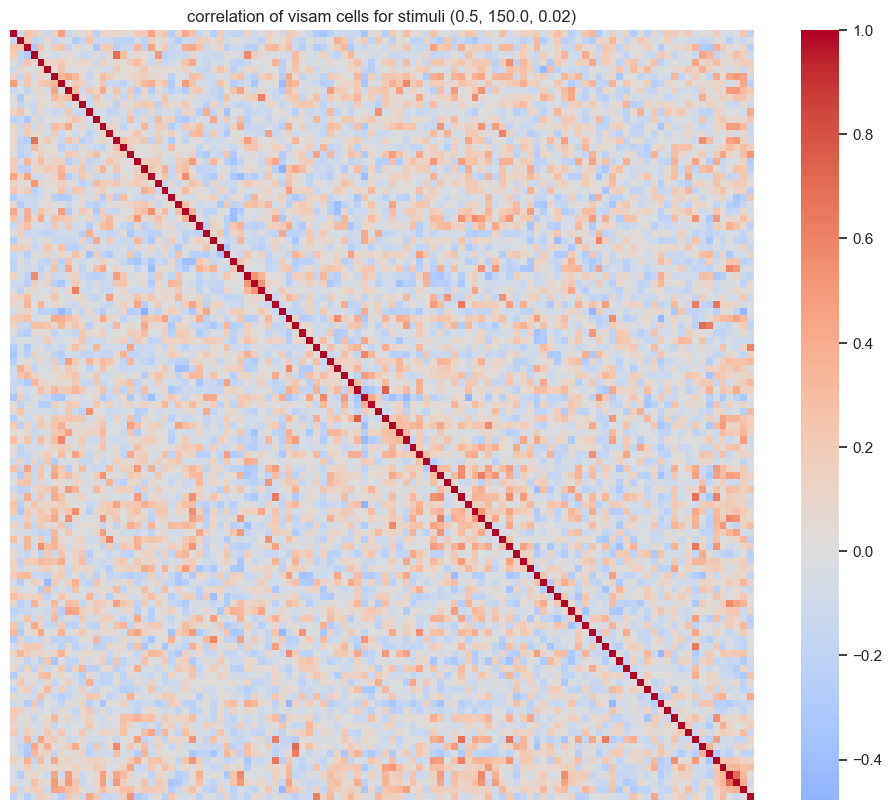

In [57]:
unit_ids = region_ids_VISam
parameter_key = (0.5, 150.0, 0.02)
corr, mean, std = compute_corr(unit_ids, parameter_key)

print("Average correlation is:", mean)
print("Standard deviation of correlation is:", std)
plt.figure(figsize=(12, 10))
plt.title(f"correlation of visam cells for stimuli {parameter_key}")
sns.heatmap(corr, cmap="coolwarm", center=0, yticklabels=False , xticklabels=False)

In [58]:
# correlation per area, given static grating type

parameter_key = (0.5, 150.0, 0.02)

for area in visual_cortex:
    
    unit_ids = oursession.units[oursession.units['ecephys_structure_acronym'] == area].index.values
    corr, mean, std = compute_corr(unit_ids, parameter_key)
    
    print("Correlation in:", area)
    print("Average correlation:", mean)
    print("Standard deviation of correlation:", std)

Correlation in: VISam
Average correlation: 0.03330802402984781
Standard deviation of correlation: 0.18246826353639228
Correlation in: VISp
Average correlation: 0.03724106716741745
Standard deviation of correlation: 0.19716267759648012
Correlation in: VISal
Average correlation: 0.01932669664385374
Standard deviation of correlation: 0.2041232132446498
Correlation in: VISl
Average correlation: 0.012419119438586899
Standard deviation of correlation: 0.1812503722189582
Correlation in: VISrl
Average correlation: 0.011672915107065703
Standard deviation of correlation: 0.1874293044073783
Correlation in: VISpm
Average correlation: nan
Standard deviation of correlation: nan


In [61]:
for area in visual_cortex:
    
    unit_ids = oursession.units[oursession.units['ecephys_structure_acronym'] == area].index.values
    corr, mean, std = compute_corr(unit_ids, None)
    
    print("Correlation in:", area)
    print("Average correlation:", mean)
    print("Standard deviation of correlation:", std)

Correlation in: VISam
Average correlation: 0.03523496512988226
Standard deviation of correlation: 0.09964925977910492
Correlation in: VISp
Average correlation: 0.04541997547399654
Standard deviation of correlation: 0.10281449416264211
Correlation in: VISal
Average correlation: 0.029296403312470284
Standard deviation of correlation: 0.1144399641238968
Correlation in: VISl
Average correlation: 0.020440282938107426
Standard deviation of correlation: 0.10102693963203248
Correlation in: VISrl
Average correlation: 0.017895287564721914
Standard deviation of correlation: 0.09696323493089912
Correlation in: VISpm
Average correlation: nan
Standard deviation of correlation: nan


<Axes: title={'center': 'correlation of visam cells activations overall'}>

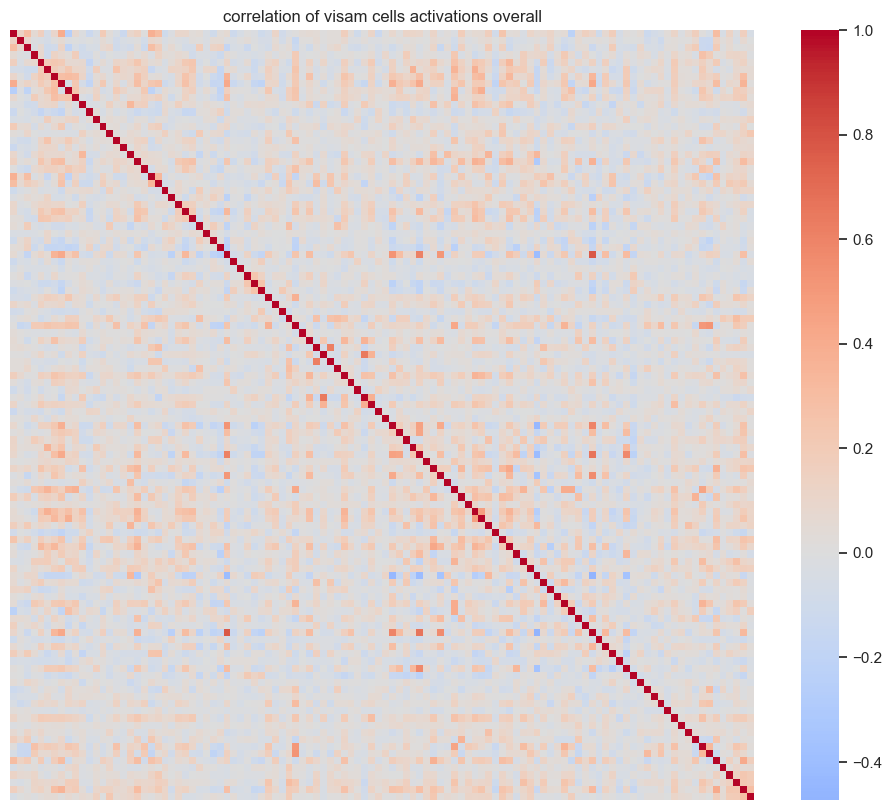

In [62]:
unit_ids = region_ids_VISam

corr, _, _ = compute_corr(unit_ids, None)
plt.figure(figsize=(12, 10))
plt.title(f"correlation of visam cells activations overall")
sns.heatmap(corr,cmap="coolwarm", center=0, yticklabels=False , xticklabels=False)

## 2. 4 Spike count and firing rate

We now pick at random pairs of neurons belonging to different areas of the visual cortex, not considering the outliers detected in the previous section.
We aim to spot more similar activation patterns in neurons of the same area rather than between neurons of different areas.

In [63]:
from random import choice

choice_VISp_1, choice_VISp_2  = choice(region_ids_VISp), choice(region_ids_VISp)
print('Random choices in VISp:', choice_VISp_1, choice_VISp_2)

choice_VISal_1, choice_VISal_2  = choice(region_ids_VISal), choice(region_ids_VISal)
print('Random choices in VISal:', choice_VISal_1, choice_VISal_2)

choice_VISam_1, choice_VISam_2  = choice(region_ids_VISam), choice(region_ids_VISam)
print('Random choices in VISam:', choice_VISam_1, choice_VISam_2)

choice_VISl_1, choice_VISl_2  = choice(region_ids_VISl), choice(region_ids_VISl)
print('Random choices in VISl:', choice_VISl_1, choice_VISl_2)

choice_VISrl_1, choice_VISrl_2  = choice(region_ids_VISrl), choice(region_ids_VISrl)
print('Random choices in VISrl:', choice_VISrl_1, choice_VISrl_2)

choices = [(choice_VISp_1, choice_VISp_2), (choice_VISal_1, choice_VISal_2), (choice_VISam_1, choice_VISam_2),
           (choice_VISl_1, choice_VISl_2), (choice_VISrl_1, choice_VISrl_2)]

Random choices in VISp: 951105377 951103934
Random choices in VISal: 951114140 951112678
Random choices in VISam: 951093349 951097708
Random choices in VISl: 951108764 951109262
Random choices in VISrl: 951116776 951116991


We first look at polar plots for neurons in the same area.

In [64]:
# area VISp
for id in choices[0]:
    area = oursession.units.loc[id, 'ecephys_structure_acronym']
    df = data_neuron_polar(id, area)
    df = df.groupby(['orientation', 'spatial_frequency', 'log_spatial_frequency'], as_index=False)['count'].sum()
    plot_neuron_polar(id, area, df)

In [65]:
# area VISal
for id in choices[1]:
    area = oursession.units.loc[id, 'ecephys_structure_acronym']
    df = data_neuron_polar(id, area)
    df = df.groupby(['orientation', 'spatial_frequency', 'log_spatial_frequency'], as_index=False)['count'].sum()
    plot_neuron_polar(id, area, df)

In [66]:
# area VISam
for id in choices[2]:
    area = oursession.units.loc[id, 'ecephys_structure_acronym']
    df = data_neuron_polar(id, area)
    df = df.groupby(['orientation', 'spatial_frequency', 'log_spatial_frequency'], as_index=False)['count'].sum()
    plot_neuron_polar(id, area, df)

In [67]:
# area VISl
for id in choices[3]:
    area = oursession.units.loc[id, 'ecephys_structure_acronym']
    df = data_neuron_polar(id, area)
    df = df.groupby(['orientation', 'spatial_frequency', 'log_spatial_frequency'], as_index=False)['count'].sum()
    plot_neuron_polar(id, area, df)

In [68]:
# area VISrl
for id in choices[4]:
    area = oursession.units.loc[id, 'ecephys_structure_acronym']
    df = data_neuron_polar(id, area)
    df = df.groupby(['orientation', 'spatial_frequency', 'log_spatial_frequency'], as_index=False)['count'].sum()
    plot_neuron_polar(id, area, df)

The patterns for neurons in the same area doesn't look identical, but for example the pair of neurons in VISrl seems to activate for smaller values of frequency, while the pair in VISam seems to be more activated for higher frequency. The scale of the activation also differs between neurons in the same couple.

Now we try to compare neurons activations using firing rate that seems a measure easier to compare.

In [69]:
# parameters_dict # phase # orientation # spatial frequency

In [70]:
def spike_times_by_parameter_onset(unit_id, gratings, parameter_key):
    '''
    Function that returns spike times of one neuron when a specific kind of static gratings is shown.
    Spikes of different experiment trials of the same kind of statuc gratings are grouped.
    ex "get_spike_times".
    '''
    spike_times_by_par = gratings.groupby(['phase','orientation','spatial_frequency']).agg(
        {'start_time': lambda x: list(x),'stop_time': lambda x: list(x)}).reset_index().drop(index=120)

    phase, orient, freq = parameter_key
    row_index = spike_times_by_par[(spike_times_by_par['phase'] == str(phase)) & 
        (spike_times_by_par['orientation'] == orient) & (spike_times_by_par['spatial_frequency'] == freq)].index[0]
    row = spike_times_by_par.iloc[row_index,:]
    start_times = row['start_time']
    stop_times = row['stop_time']

    spike_times_by_par_onset = []
    for ind, trial_start in enumerate(start_times):
        spike_times = oursession.spike_times[unit_id]
        spike_times_per_trial = spike_times[(spike_times > trial_start) & (spike_times < stop_times[ind])]
        spike_times_by_par_onset.append([i-trial_start for i in spike_times_per_trial])

    return spike_times_by_par_onset 

In [71]:
def firing_rate(t, spikes, bin_size = 0.02):

    n_spikes = 0
    n_trials = len(spikes)

    for trial in spikes:
        trial = np.array(trial)
        n_spikes_in_trial = len(trial[(trial > t) & (trial < t + bin_size)])
        n_spikes += n_spikes_in_trial
    
    return n_spikes/(n_trials*bin_size)

In [72]:
static_gratings = oursession.get_stimulus_table("static_gratings")
parameter_key = (0.0, 30.0, 0.04)

spikes_VISp_1 = spike_times_by_parameter_onset(choice_VISp_1, static_gratings, parameter_key)
spikes_VISp_2 = spike_times_by_parameter_onset(choice_VISp_2, static_gratings, parameter_key)
spikes_VISam_1 = spike_times_by_parameter_onset(choice_VISam_1, static_gratings, parameter_key)
spikes_VISam_2 = spike_times_by_parameter_onset(choice_VISam_2, static_gratings, parameter_key)
spikes_VISal_1 = spike_times_by_parameter_onset(choice_VISal_1, static_gratings, parameter_key)
spikes_VISal_2 = spike_times_by_parameter_onset(choice_VISal_2, static_gratings, parameter_key)
spikes_VISl_1 = spike_times_by_parameter_onset(choice_VISl_1, static_gratings, parameter_key)
spikes_VISl_2 = spike_times_by_parameter_onset(choice_VISl_2, static_gratings, parameter_key)
spikes_VISrl_1 = spike_times_by_parameter_onset(choice_VISrl_1, static_gratings, parameter_key)
spikes_VISrl_2 = spike_times_by_parameter_onset(choice_VISrl_2, static_gratings, parameter_key)

spikes_list = [spikes_VISp_1, spikes_VISp_2, spikes_VISal_1, spikes_VISal_2, spikes_VISam_1, spikes_VISam_2,
                spikes_VISl_1, spikes_VISl_2, spikes_VISrl_1, spikes_VISrl_2]

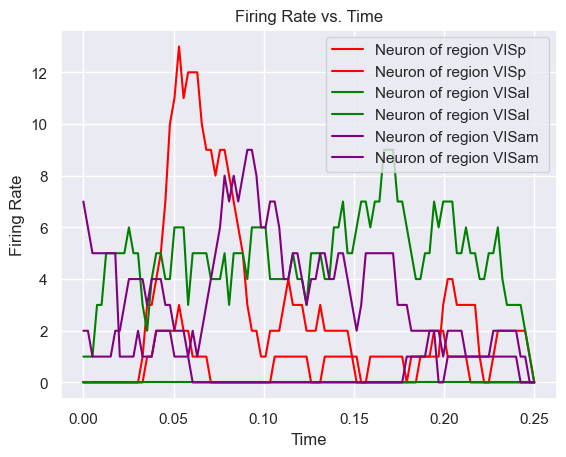

In [73]:
time_points = np.linspace(0, 0.25, 100)

plt.figure()

count = 0

for x in spikes_list[:6]:
    firing_rates = [firing_rate(t, x) for t in time_points]

    if count == 0 or count == 1:  
        name = 'VISp'
    elif count == 2 or count == 3:
        name = 'VISal'
    elif count == 4 or count == 5:
        name = 'VISam'
    elif count == 6 or count == 7:
        name = 'VISl'
    elif count == 8 or count == 9:
        name = 'VISrl'

    color_dict = {'VISp': 'red', 'VISal': 'green', 'VISam': 'purple', 'VISl': 'orange', 'VISrl': 'blue'}
    plt.plot(time_points, firing_rates, color = color_dict[name], label=f'Neuron of region {name} '.format(spikes_list.index(x) + 1))
    count += 1

plt.xlabel("Time")
plt.ylabel("Firing Rate")
plt.title("Firing Rate vs. Time")
plt.grid(True)
plt.legend()  
plt.show()

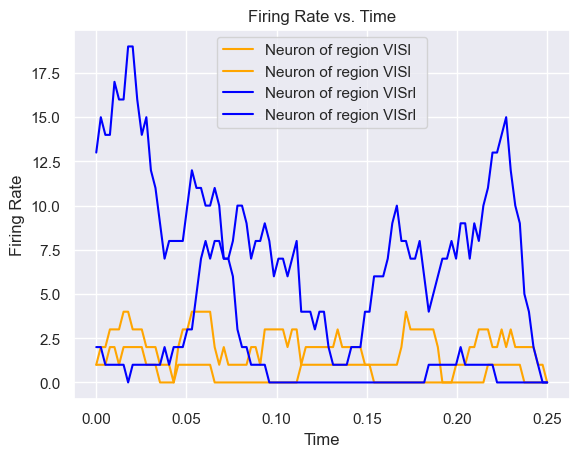

In [74]:
time_points = np.linspace(0, 0.25, 100)

plt.figure()

count = 6

for x in spikes_list[6:]:
    firing_rates = [firing_rate(t, x) for t in time_points]

    if count == 0 or count == 1:  
        name = 'VISp'
    elif count == 2 or count == 3:
        name = 'VISal'
    elif count == 4 or count == 5:
        name = 'VISam'
    elif count == 6 or count == 7:
        name = 'VISl'
    elif count == 8 or count == 9:
        name = 'VISrl'

    color_dict = {'VISp': 'red', 'VISal': 'green', 'VISam': 'purple', 'VISl': 'orange', 'VISrl': 'blue'}
    plt.plot(time_points, firing_rates, color = color_dict[name], label=f'Neuron of region {name} '.format(spikes_list.index(x) + 1))
    count += 1

plt.xlabel("Time")
plt.ylabel("Firing Rate")
plt.title("Firing Rate vs. Time")
plt.grid(True)
plt.legend()  
plt.show()

By looking at these graphs, neurons of the same area seem to show quite similar behaviors, reaching similar peaks.

We can now compare the polar plots of the spike counts and the plots of the firing rates. It should be true that neurons that show high peaks in the firing rate plots in response to some specific stimulus may also display high spike counts for the same grating. 

Let's take for example a neuron in the region VISp and plot its firing rates in response to every possible static grating.

In [75]:
choice_VISp_1 = 951104075
print('Chosen neuron index:', choice_VISp_1)

Chosen neuron index: 951104075


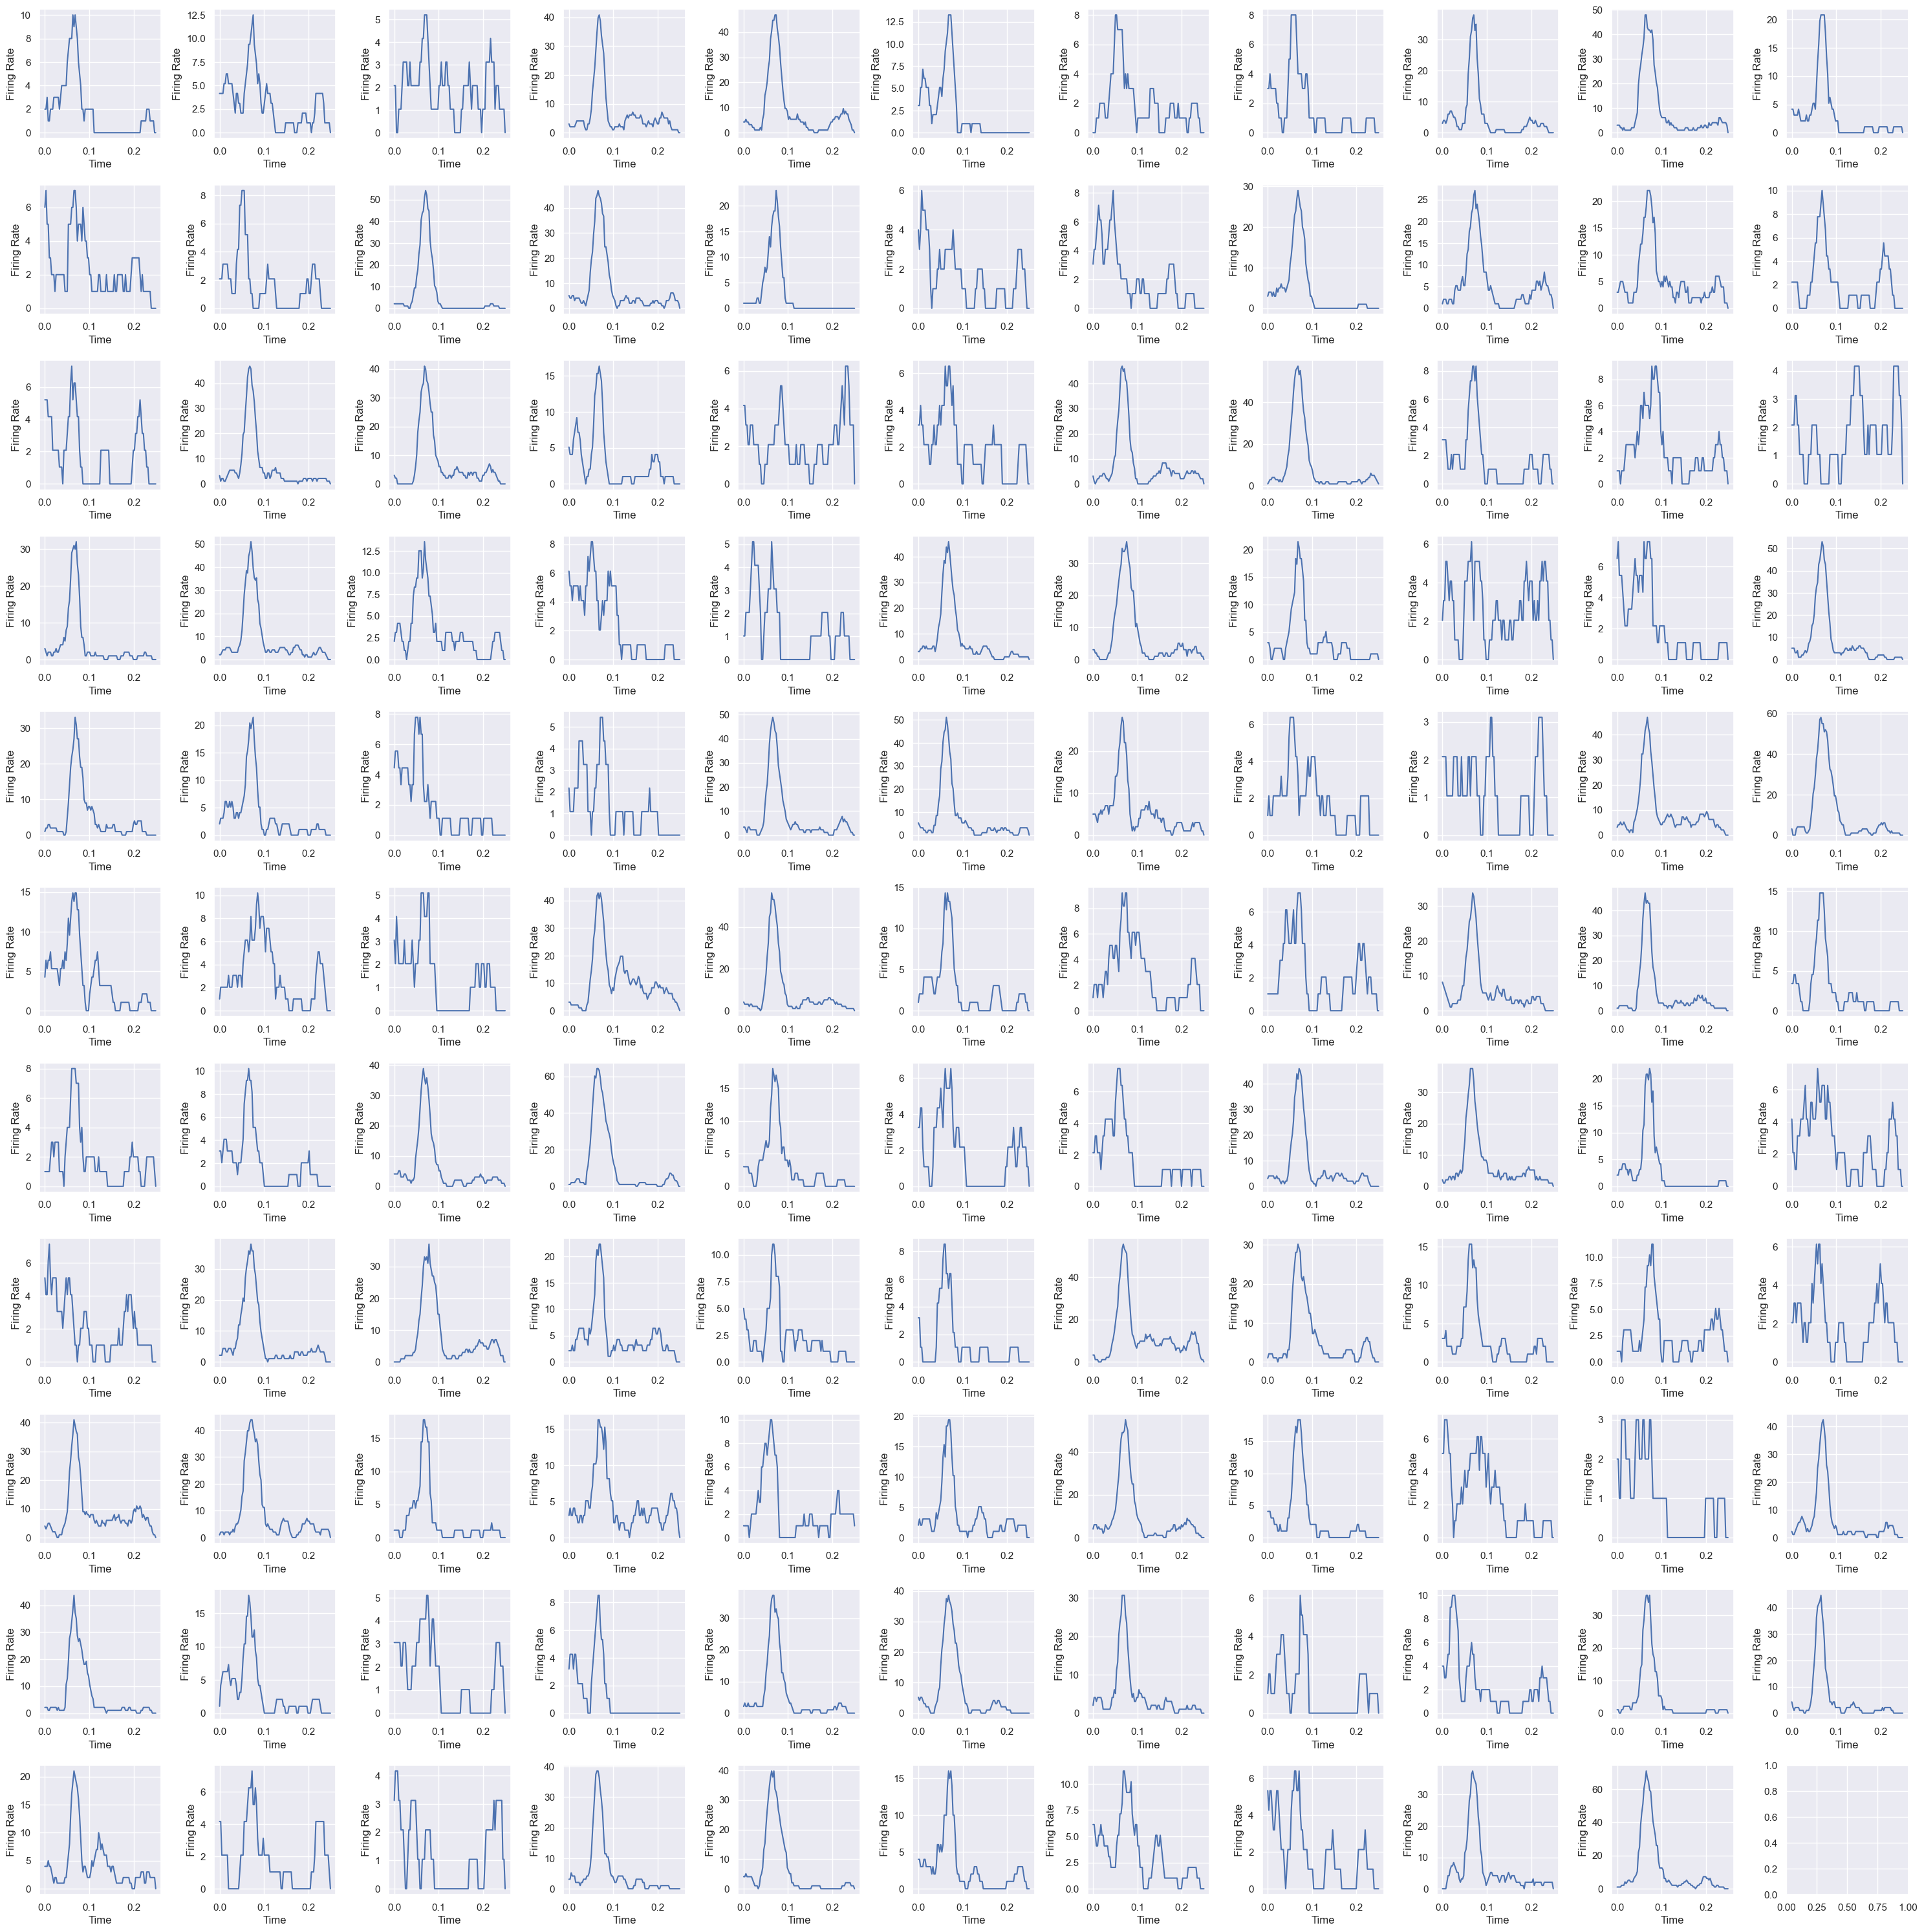

In [76]:
stimulus_trials = static_gratings.groupby(['phase','orientation','spatial_frequency']).agg({
    'start_time': lambda x: list(x),
    'stop_time': lambda x: list(x)
}).reset_index().drop(index=120)

num_trials = stimulus_trials.shape[0]       # get number of static gratings

time_points = np.linspace(0, 0.25, 100)


num_rows = int(np.ceil(np.sqrt(num_trials)))
num_cols = int(np.ceil(num_trials / num_rows))


fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 30))

phases = list(set(static_gratings['phase']))        # create a list with all the possible phases
phases.remove('null')                               # remove 'null'
angles = list(set(static_gratings['orientation']))  # create a list with all possible orientations
angles.remove('null')                               # remove 'null'
spatial_frequency = list(set(static_gratings['spatial_frequency']))  # create a list with all possible spatial frequencies
spatial_frequency.remove('null')                                     # remove 'null'



count = 0
# Iterate over each possible phase, orientation and spatial frequency combination
for phase in phases:
    for angle in angles:
        for frequency in spatial_frequency:
            parameter_key = (phase, angle, frequency)
            spikes = spike_times_by_parameter_onset(choice_VISp_1, static_gratings, parameter_key)

            firing_rates = [firing_rate(t, spikes) for t in time_points]

            row_idx = count // num_cols
            col_idx = count % num_cols

            count += 1

            ax = axes[row_idx, col_idx] 
            ax.plot(time_points, firing_rates)
            ax.set_xlabel("Time")
            ax.set_ylabel("Firing Rate")
            ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


We see that the neuron responds differently to the various gratings. We select 3 plots that seems to represent a high response and 3 that seem to represent a low response and ccompare our initial intuition with the spike count plot from before. We expect that stimuli that lead to high spike counts will also yield high firing rates and viceversa.

Choices of parameters that lead to HIGH firing rates: 
- phase = 0.75, angle = 30.0, spatial frequency = 0.02
- phase = 0.0, angle = 60.0, spatial frequency = 0.04
- phase = 0.0, angle = 150.0, spatial frequency = 0.02

Choices of parameters that lead to LOW firing rates: 
- phase = 0.0, angle = 0.0, spatial frequency = 0.32
- phase = 0.75, angle = 30.0, spatial frequency = 0.16
- phase = 0.0, angle = 0.0, spatial frequency = 0.16

In [77]:
# we select 3 gratings that give high firing rate
high_firing_VISp = [spike_times_by_parameter_onset(choice_VISp_1, static_gratings, ('0.75', 30.0, 0.02)), spike_times_by_parameter_onset(choice_VISp_1, static_gratings, ('0.0', 60.0, 0.04)), spike_times_by_parameter_onset(choice_VISp_1, static_gratings, ('0.0', 150.0, 0.02))] 

# we select 3 gratings that give low firing rate
low_firing_VISp = [spike_times_by_parameter_onset(choice_VISp_1, static_gratings, ('0.0', 0.0, 0.32)), spike_times_by_parameter_onset(choice_VISp_1, static_gratings, ('0.75', 30.0, 0.16)), spike_times_by_parameter_onset(choice_VISp_1, static_gratings, ('0.0', 0.0, 0.16))] 

We visualize again the single firng rate plots to verifiy that our choice of parameters is correct.

<Figure size 640x480 with 0 Axes>

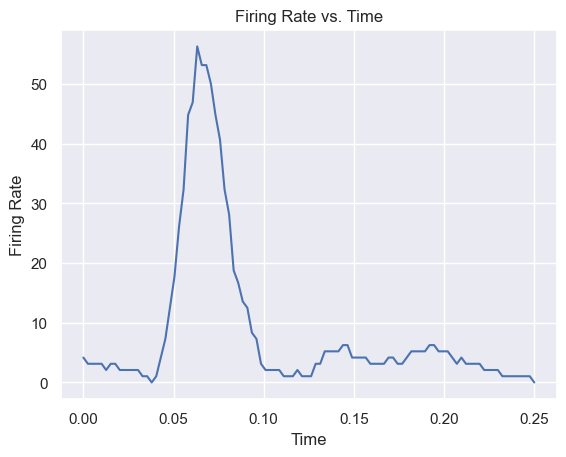

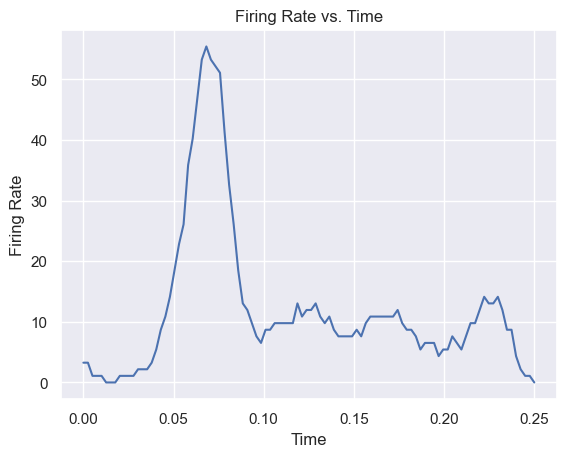

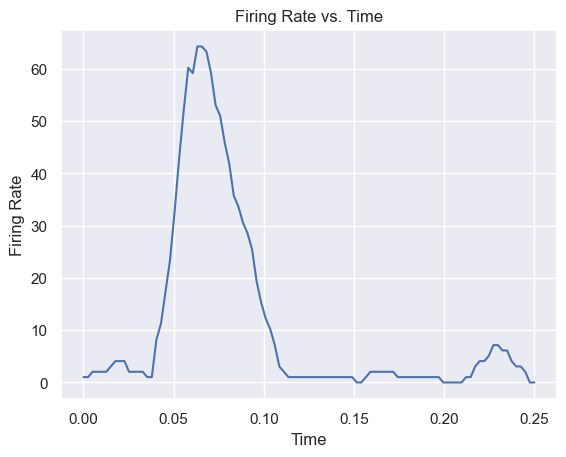

In [78]:
time_points = np.linspace(0, 0.25, 100)

plt.figure()


for x in high_firing_VISp:
    plt.figure()


    firing_rates = [firing_rate(t, x) for t in time_points]
    plt.plot(time_points, firing_rates)




    plt.xlabel("Time")
    plt.ylabel("Firing Rate")
    plt.title("Firing Rate vs. Time")
    plt.grid(True)
    plt.show()



<Figure size 640x480 with 0 Axes>

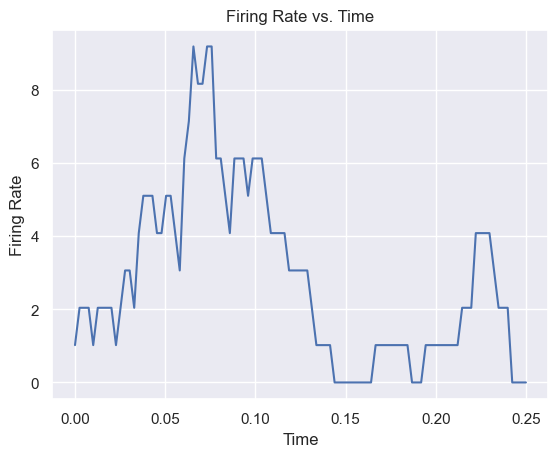

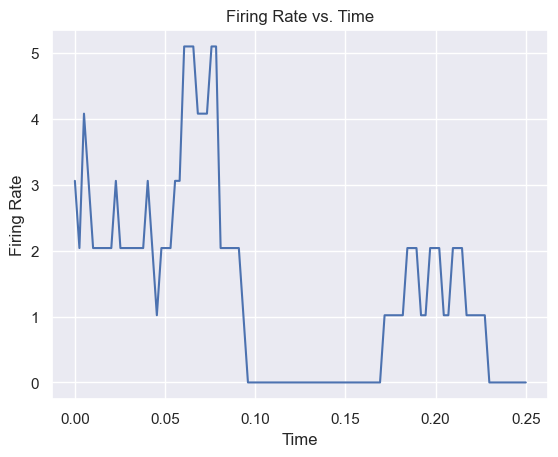

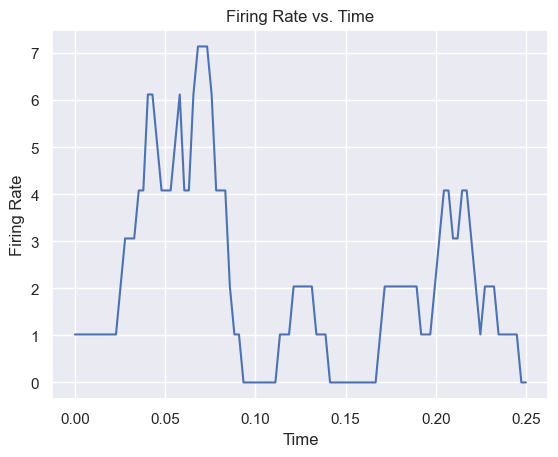

In [79]:
time_points = np.linspace(0, 0.25, 100)

plt.figure()


for x in low_firing_VISp:
    plt.figure()


    firing_rates = [firing_rate(t, x) for t in time_points]
    plt.plot(time_points, firing_rates)




    plt.xlabel("Time")
    plt.ylabel("Firing Rate")
    plt.title("Firing Rate vs. Time")
    plt.grid(True)
    plt.show()


Let's visualize the plot of the spike counts for the given neuron and the analyzed phases 0.0 and 0.75 (we take just these two phases since the others do not appear in the previous analysis).



In [80]:
parameters_dict, spikes, unit_ids = load_data(session_id)

id = int(choice_VISp_1)
area = oursession.units.loc[id, 'ecephys_structure_acronym']
df = data_neuron_polar(id, area)
phase = [0.00, 0.75]
for ph in phase:
    df_ph = df[df['phase'] == ph]
    plot_neuron_polar(id, area, df_ph)

We indeed see that for the parameters that lead to high firing rates also the spike counts are high and, viceversa, for the parameters that lead to low firing rates the count is low, i.e. for (phase = 0.75, angle = 30.0, spatial frequency = 0.02), (phase = 0.0, angle = 60.0, spatial frequency = 0.04), (phase = 0.0, angle = 150.0, spatial frequency = 0.02) the count is high and for (phase = 0.0, angle = 0.0, spatial frequency = 0.32), (phase = 0.75, angle = 30.0, spatial frequency = 0.16), (phase = 0.0, angle = 0.0, spatial frequency = 0.16) the count is low.

This emphasizes that our hypothesis is correct.

## 2.5 Clustering and Classification

### Clustering

In [81]:
import random
import xgboost as xgb

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression


from matplotlib import cm

from itertools import permutations

### Visualizing clusters

In [82]:
visual_units_labels = ['VISam', 'VISp', 'VISl', 'VISal', 'VISrl', 'VISpm']
visual_clustering_data = df_t[(df_t["labels"].isin(visual_units_labels))]

In [83]:
visual_clustering_dict = visual_clustering_data.drop(columns=["labels"]).apply(lambda row: row.tolist(), axis = 1).to_dict()

for value in visual_clustering_dict.values():
    assert len(value) == 120

visual_clustering_matrix = np.vstack(list(visual_clustering_dict.values()))

Here we encode the categorical labels in a variable that ranges from 0 to 5.

In [84]:
def associate_index(label):
    return visual_units_labels.index(label)

visual_clustering_data["mapped_labels"] = visual_clustering_data["labels"].apply(associate_index)

/var/folders/gd/b2d40bms7s3f8y4f31x7pk1r0000gn/T/ipykernel_55056/3685311478.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [85]:
visual_clustering_data.labels.value_counts()

VISam    135
VISp      94
VISal     89
VISl      78
VISrl     47
Name: labels, dtype: int64

Applying 2d TSNE on the encoding (please note that we use just 5 clusters since we have no data for 'VISpm').

/var/folders/gd/b2d40bms7s3f8y4f31x7pk1r0000gn/T/ipykernel_55056/2033991370.py:7: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



Text(0.5, 1.0, 'Clusters identified visualized in 2d using t-SNE')

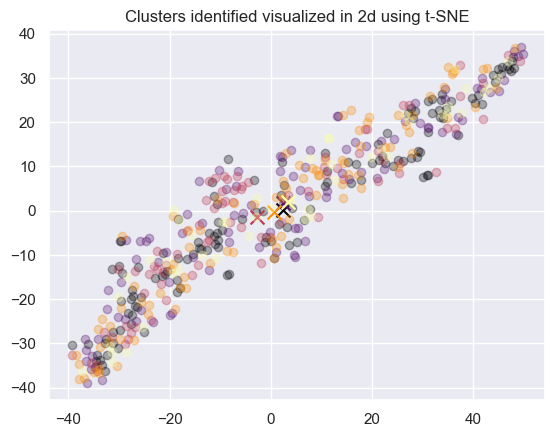

In [86]:
tsne_2d = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_2d = tsne_2d.fit_transform(visual_clustering_matrix)

x = [x for x, y in vis_2d]
y = [y for x, y in vis_2d]

colormap = cm.get_cmap("inferno", 5)

for label_ind, color in enumerate(colormap.colors):
    xs = np.array(x)[visual_clustering_data.mapped_labels == label_ind]
    ys = np.array(y)[visual_clustering_data.mapped_labels == label_ind]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color= color, s=100, alpha = 1)
plt.title("Clusters identified visualized in 2d using t-SNE")

### KMeans Clusters performance

Calculating the performance of the KMeans Clustering

In [87]:
kmeans_model = KMeans(n_clusters= 6, init="k-means++", random_state= 42)
kmeans_model.fit(visual_clustering_matrix)
visual_clustering_data["clusters"] = kmeans_model.labels_

/var/folders/gd/b2d40bms7s3f8y4f31x7pk1r0000gn/T/ipykernel_55056/2174837933.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [88]:
len(visual_clustering_data)

443

Notice again that we don't have information on one visual part of the brain.

In [89]:
real_labels = visual_clustering_data["labels"].unique()
clusters = list(range(len(real_labels)))
argmax_accuracy = clusters
n_neurons = len(visual_clustering_data) 
min_cluster_assignment = list()
max_accuracy = 0

for permutation in permutations(clusters):
    correct_clusters = 0
    for label, real_label in zip(permutation, real_labels):
        correct_clusters += len(visual_clustering_data[(visual_clustering_data["labels"] == real_label) & (visual_clustering_data["clusters"] == label)])

    accuracy = (correct_clusters/n_neurons)*100

    if accuracy >= max_accuracy:
        max_accuracy = accuracy
        argmax_accuracy = permutation

In [90]:
max_accuracy

26.86230248306998

In [91]:
argmax_accuracy

(1, 2, 3, 0, 4)

### XGBoost Classification analysis

In [92]:
X = visual_clustering_data.drop(columns = ["labels", "mapped_labels", "clusters"])
y = visual_clustering_data["mapped_labels"]

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, stratify = y)

In [94]:
X_train.shape

(354, 120)

In [95]:
model = xgb.XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='multi:softmax')
linear_model = LogisticRegression()
dummy_strat_model = DummyClassifier(strategy= "stratified", random_state = 42)
dummy_uni_model = DummyClassifier(strategy= "uniform", random_state = 42)

In [96]:
# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=10, shuffle=True)

model_accuracy = []
linear_model_accuracy = []
dummy_strat_accuracy = []
dummy_uni_accuracy = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model, predict and calculate accuracy
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    model_accuracy.append(acc)

    #Fit the linear model
    linear_model.fit(X_train, y_train)
    linear_preds = linear_model.predict(X_test)
    linear_acc = accuracy_score(y_test, linear_preds)
    linear_model_accuracy.append(linear_acc)

    #Fit the dummy and predict
    dummy_strat_model.fit(X_train, y_train)
    strat_preds = dummy_strat_model.predict(X_test)
    strat_acc = accuracy_score(y_test, strat_preds)
    dummy_strat_accuracy.append(strat_acc)

    #Fit the uniform dummy and predict
    dummy_uni_model.fit(X_train, y_train)
    uni_preds = dummy_uni_model.predict(X_test)
    uni_acc = accuracy_score(y_test, uni_preds)
    dummy_uni_accuracy.append(uni_acc)

print(f"Accuracy for our model: {np.mean(model_accuracy)} ± {np.std(model_accuracy)}")
print(f"Accuracy for a stratified dummy classifier: {np.mean(dummy_strat_accuracy)} ± {np.std(dummy_strat_accuracy)}")
print(f"Accuracy for a uniform dummy classifier: {np.mean(dummy_uni_accuracy)} ± {np.std(dummy_uni_accuracy)}")


Accuracy for our model: 0.2821212121212121 ± 0.04414048955414731
Accuracy for a stratified dummy classifier: 0.16242424242424242 ± 0.01875934620648834
Accuracy for a uniform dummy classifier: 0.1625757575757576 ± 0.009742239657676115


In [97]:
from scipy.stats import ttest_ind
first_test = ttest_ind(model_accuracy, dummy_strat_accuracy, equal_var=False, alternative = "greater")
second_test = ttest_ind(model_accuracy, dummy_uni_accuracy, equal_var = False, alternative = "greater")

print(f"XGBoost Classifier vs. Dummy Stratified Classifier -> Statistic: {first_test.statistic}; P-value: {first_test.pvalue}")
print(f"XGBoost Classifier vs. Dummy Uniform Classifier -> Statistic: {second_test.statistic}; P-value: {second_test.pvalue}")

XGBoost Classifier vs. Dummy Stratified Classifier -> Statistic: 7.487081470312779; P-value: 3.4237001066010983e-06
XGBoost Classifier vs. Dummy Uniform Classifier -> Statistic: 7.9339395472263465; P-value: 6.829354474265485e-06


In [99]:
all_accuracies = [model_accuracy, linear_model_accuracy ,dummy_strat_accuracy, dummy_uni_accuracy]
model_names = ["XGBoost", "Logistic Classifier", "Dummy Stratified", "Dummy Uniform"]

In [100]:
plt.figure(figsize=(10, 6), dpi= 1200)
sns.boxplot(data=all_accuracies)
plt.xticks(ticks=range(len(model_names)), labels=model_names)
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.show()

### Now performing the same analysis on normalized data

Preprocessing the data

In [101]:
visual_clustering_dict_norm = {key : np.array(value)/sum(value) for key, value in visual_clustering_dict.items()}

In [102]:
visual_clustering_data_norm = pd.DataFrame(visual_clustering_dict_norm).transpose()

In [103]:
#We don't actually need the labels (just the mapped ones)
visual_clustering_data_norm["labels"] = visual_clustering_data["labels"]

In [104]:
visual_clustering_data_norm["mapped_labels"] = visual_clustering_data["mapped_labels"]

In [105]:
X_norm = visual_clustering_data_norm.drop(columns = ["labels", "mapped_labels"])
y_norm = visual_clustering_data_norm["mapped_labels"]

In [106]:
model_norm = xgb.XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='multi:softmax')
linear_model_norm = LogisticRegression()
dummy_strat_model_norm = DummyClassifier(strategy= "stratified", random_state = 42)
dummy_uni_model_norm = DummyClassifier(strategy= "uniform", random_state = 42)

In [107]:
# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=10, shuffle=True)

model_norm_accuracy = []
linear_model_norm_accuracy = []
dummy_strat_norm_accuracy = []
dummy_uni_norm_accuracy = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X_norm.iloc[train_index], X_norm.iloc[test_index]
    y_train, y_test = y_norm.iloc[train_index], y_norm.iloc[test_index]

    # Fit the model, predict and calculate accuracy
    model_norm.fit(X_train, y_train)
    preds = model_norm.predict(X_test)
    acc_norm = accuracy_score(y_test, preds)
    model_norm_accuracy.append(acc_norm)

    #Fit the linear model
    linear_model_norm.fit(X_train, y_train)
    linear_preds_norm = linear_model_norm.predict(X_test)
    linear_acc_norm = accuracy_score(y_test, linear_preds_norm)
    linear_model_norm_accuracy.append(linear_acc_norm)


    #Fit the dummy and predict
    dummy_strat_model_norm.fit(X_train, y_train)
    strat_preds = dummy_strat_model_norm.predict(X_test)
    strat_acc_norm = accuracy_score(y_test, strat_preds)
    dummy_strat_norm_accuracy.append(strat_acc_norm)

    #Fit the uniform dummy and predict
    dummy_uni_model_norm.fit(X_train, y_train)
    uni_preds = dummy_uni_model_norm.predict(X_test)
    uni_acc_norm = accuracy_score(y_test, uni_preds)
    dummy_uni_norm_accuracy.append(uni_acc_norm)

print(f"Accuracy for our model: {np.mean(model_norm_accuracy)} ± {np.std(model_norm_accuracy)}")
print(f"Accuracy for a stratified dummy classifier: {np.mean(dummy_strat_norm_accuracy)} ± {np.std(dummy_strat_norm_accuracy)}")
print(f"Accuracy for a uniform dummy classifier: {np.mean(dummy_uni_norm_accuracy)} ± {np.std(dummy_uni_norm_accuracy)}")


Accuracy for our model: 0.3476262626262626 ± 0.07664066113819759
Accuracy for a stratified dummy classifier: 0.16242424242424242 ± 0.01875934620648834
Accuracy for a uniform dummy classifier: 0.1625757575757576 ± 0.009742239657676115


In [108]:
from scipy.stats import ttest_ind
first_test = ttest_ind(model_norm_accuracy, dummy_strat_norm_accuracy, equal_var=False, alternative = "greater")
second_test = ttest_ind(model_norm_accuracy, dummy_uni_norm_accuracy, equal_var = False, alternative = "greater")

print(f"XGBoost Classifier vs. Dummy Stratified Classifier -> Statistic: {first_test.statistic}; P-value: {first_test.pvalue}")
print(f"XGBoost Classifier vs. Dummy Uniform Classifier -> Statistic: {second_test.statistic}; P-value: {second_test.pvalue}")

XGBoost Classifier vs. Dummy Stratified Classifier -> Statistic: 7.041622515718471; P-value: 1.700542651688759e-05
XGBoost Classifier vs. Dummy Uniform Classifier -> Statistic: 7.185741254054635; P-value: 2.1894223677781582e-05


In [109]:
import seaborn as sns

all_accuracies = [model_norm_accuracy, linear_model_norm_accuracy, dummy_strat_norm_accuracy, dummy_uni_norm_accuracy]
model_names = ["XGBoost", "Logistic Classifier", "Dummy Stratified", "Dummy Uniform"]

plt.figure(figsize=(10, 6), dpi=1200)
sns.boxplot(data=all_accuracies)
plt.xticks(ticks=range(len(model_names)), labels=model_names)
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies from normalized data')
plt.show()

## 2.6 Responde by area

In [110]:
parameters_dict_visam, spikes_visam, unit_ids_visam = load_data(session_id, area="VISam")
parameters_dict_visp, spikes_visp, unit_ids_visp = load_data(session_id, area="VISp")
parameters_dict_visal, spikes_visal, unit_ids_visal = load_data(session_id, area="VISal")
parameters_dict_visrl, spikes_visrl, unit_ids_visrl = load_data(session_id, area="VISrl")
parameters_dict_visl, spikes_visl, unit_ids_visl = load_data(session_id, area="VISl")
# area is optional, you can load the data
# for all the units.
# This call will take a couple of minutes

In [111]:
res_visam = dict()
res_visp = dict()
res_visal = dict()
res_visrl = dict()
res_visl = dict()

for unit_id in unit_ids_visam:
    spike_avg_dict = spike_average_by_parameter(parameters_dict_visam, spikes_visam, unit_id)
    spike_avg = sum(spike_avg_dict.values()) / len(spike_avg_dict)
    if spike_avg > 1:
        res_visam[unit_id] = spike_avg_dict

for unit_id in unit_ids_visp:
    spike_avg_dict = spike_average_by_parameter(parameters_dict_visp, spikes_visp, unit_id)
    spike_avg = sum(spike_avg_dict.values()) / len(spike_avg_dict)
    if spike_avg > 1:
        res_visp[unit_id] = spike_avg_dict

for unit_id in unit_ids_visal:
    spike_avg_dict = spike_average_by_parameter(parameters_dict_visal, spikes_visal, unit_id)
    spike_avg = sum(spike_avg_dict.values()) / len(spike_avg_dict)
    if spike_avg > 1:
        res_visal[unit_id] = spike_avg_dict

for unit_id in unit_ids_visrl:
    spike_avg_dict = spike_average_by_parameter(parameters_dict_visrl, spikes_visrl, unit_id)
    spike_avg = sum(spike_avg_dict.values()) / len(spike_avg_dict)
    if spike_avg > 1:
        res_visrl[unit_id] = spike_avg_dict

for unit_id in unit_ids_visl:
    spike_avg_dict = spike_average_by_parameter(parameters_dict_visl, spikes_visl, unit_id)
    spike_avg = sum(spike_avg_dict.values()) / len(spike_avg_dict)
    if spike_avg > 1:
        res_visl[unit_id] = spike_avg_dict



In [112]:
def get_agg_val(res):
    new_res = dict()
    total = len(res.keys())
    unit = list(res.keys())[0]
    for k in res[unit].keys():
        val = 0
        for unit in res.keys():
            val += res[unit][k]
        val /= total
        new_res[k] = val

    return new_res

In [113]:
new_res_visam = get_agg_val(res_visam)
new_res_visp = get_agg_val(res_visp)
new_res_visal = get_agg_val(res_visal)
new_res_visrl = get_agg_val(res_visrl)
new_res_visl = get_agg_val(res_visl)

In [114]:
unique_phase_items = [0.0, 0.25, 0.5, 0.75]
print(unique_phase_items)
unique_orientation_items = [0.0, 30.0, 60.0, 90.0, 120.0, 150.0]
print(unique_orientation_items)
unique_spatial_frequency_items = [0.02, 0.04, 0.08, 0.16, 0.32]
print(unique_spatial_frequency_items)

[0.0, 0.25, 0.5, 0.75]
[0.0, 30.0, 60.0, 90.0, 120.0, 150.0]
[0.02, 0.04, 0.08, 0.16, 0.32]


In [115]:
def replace_keys(new_res):
    res = dict()
    for k, v in new_res.items():
        res[(unique_phase_items.index(k[0]),unique_orientation_items.index(k[1]),unique_spatial_frequency_items.index(k[2]))] = v
    return res

In [116]:
res_visam = replace_keys(new_res_visam)
res_visp = replace_keys(new_res_visp)
res_visal = replace_keys(new_res_visal)
res_visrl = replace_keys(new_res_visrl)
res_visl = replace_keys(new_res_visl)

In [117]:
def build_matrix(res):
    matrix = np.zeros(shape=(len(unique_phase_items), len(unique_orientation_items), len(unique_spatial_frequency_items)))
    for indices, value in res.items():
        matrix[indices[0]][indices[1]][indices[2]] = value
    return matrix

In [118]:
matrix_visam = build_matrix(res_visam)
matrix_visp = build_matrix(res_visp)
matrix_visal = build_matrix(res_visal)
matrix_visrl = build_matrix(res_visrl)
matrix_visl = build_matrix(res_visl)

In [119]:
import matplotlib.colors as mcolors

In [120]:
def plot_by_spatial_frequency(matrix):
    num_items = len(unique_spatial_frequency_items)
    fig, axes = plt.subplots(1, num_items, figsize=(num_items * 5, 5))  # Adjust figsize as needed

    colors = [(1, 1, 1), (1, 0, 0)]  # white to red
    cm = mcolors.LinearSegmentedColormap.from_list("CustomRed", colors, N=10)

    for i in range(num_items):
        ax = axes[i]
        ax.imshow(matrix[:, :, i], cmap=cm, interpolation='nearest')
        ax.set_xlabel('Orientation')
        ax.set_ylabel('Phase')
        ax.set_title(f'Spatial Frequency {unique_spatial_frequency_items[i]}')  # Add a title if needed
        ax.set_xticklabels(unique_orientation_items)
        ax.set_yticklabels(unique_phase_items)

    plt.tight_layout()  # Adjust subplot parameters to give specified padding.
    plt.show()

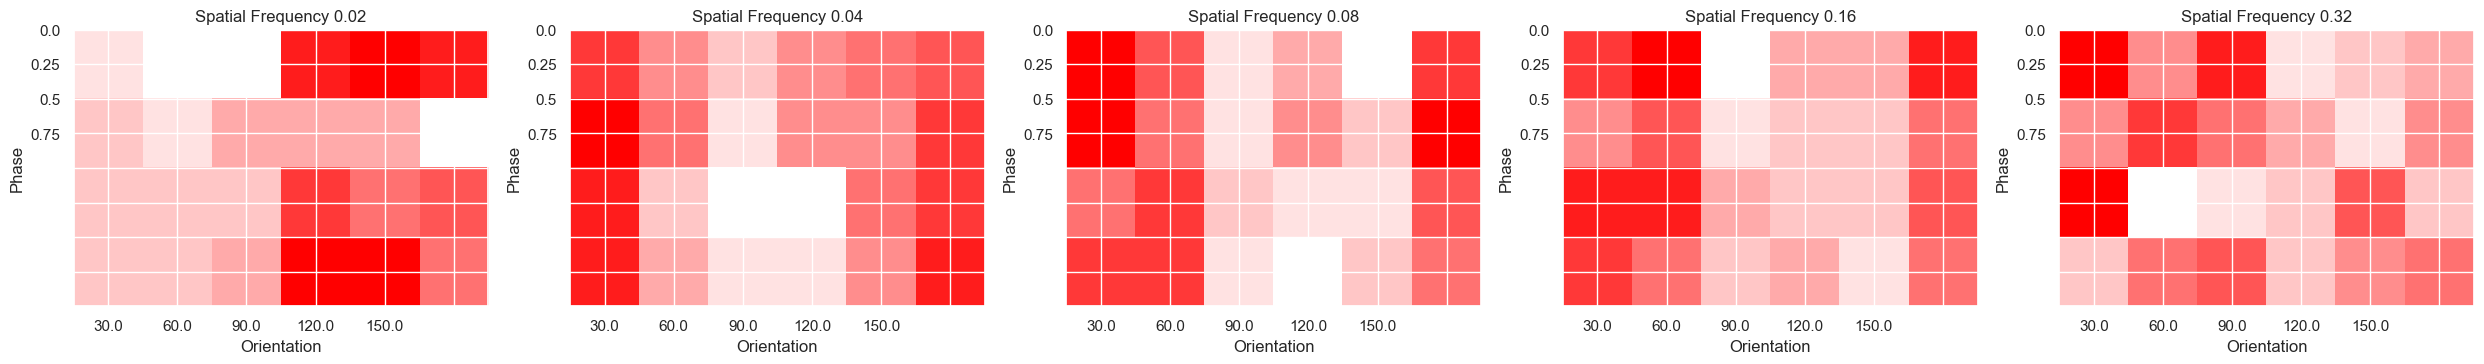

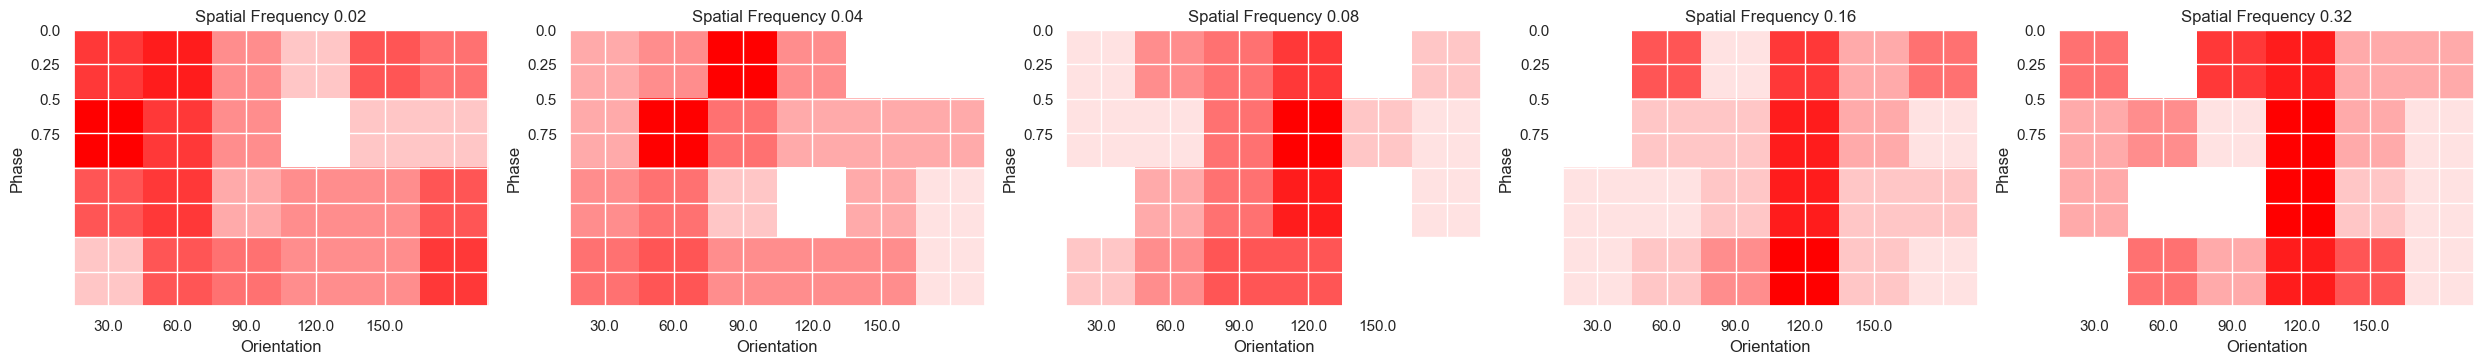

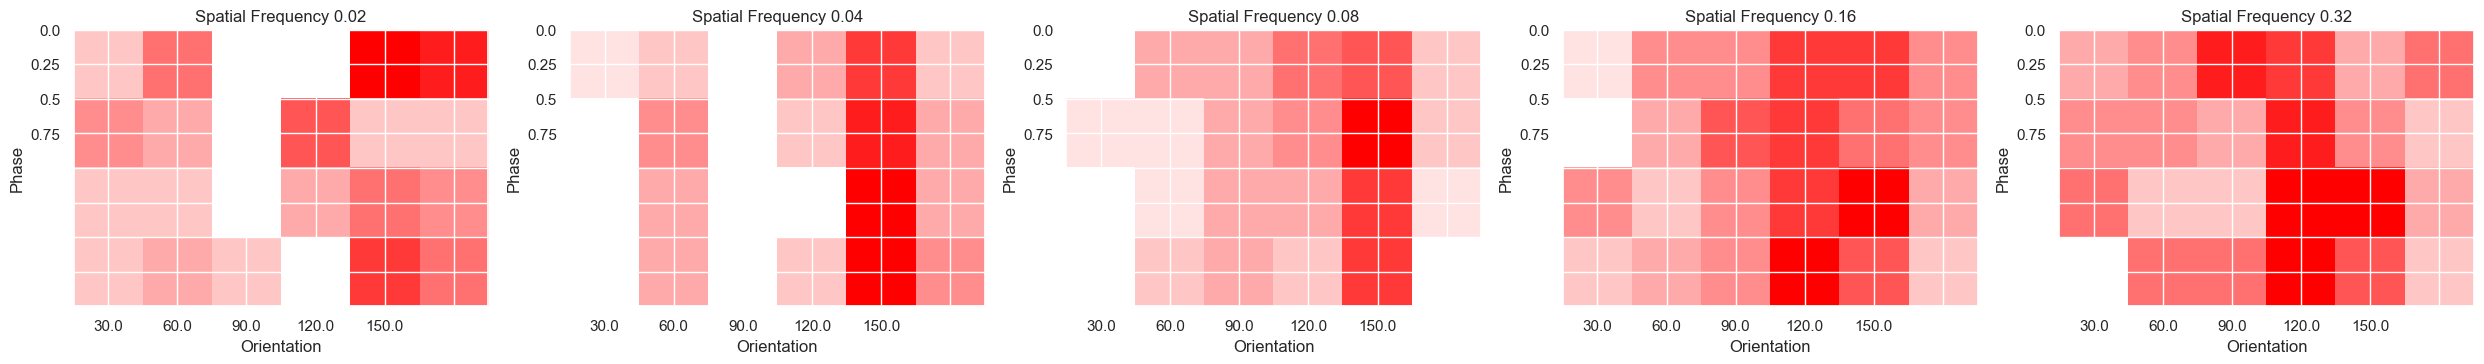

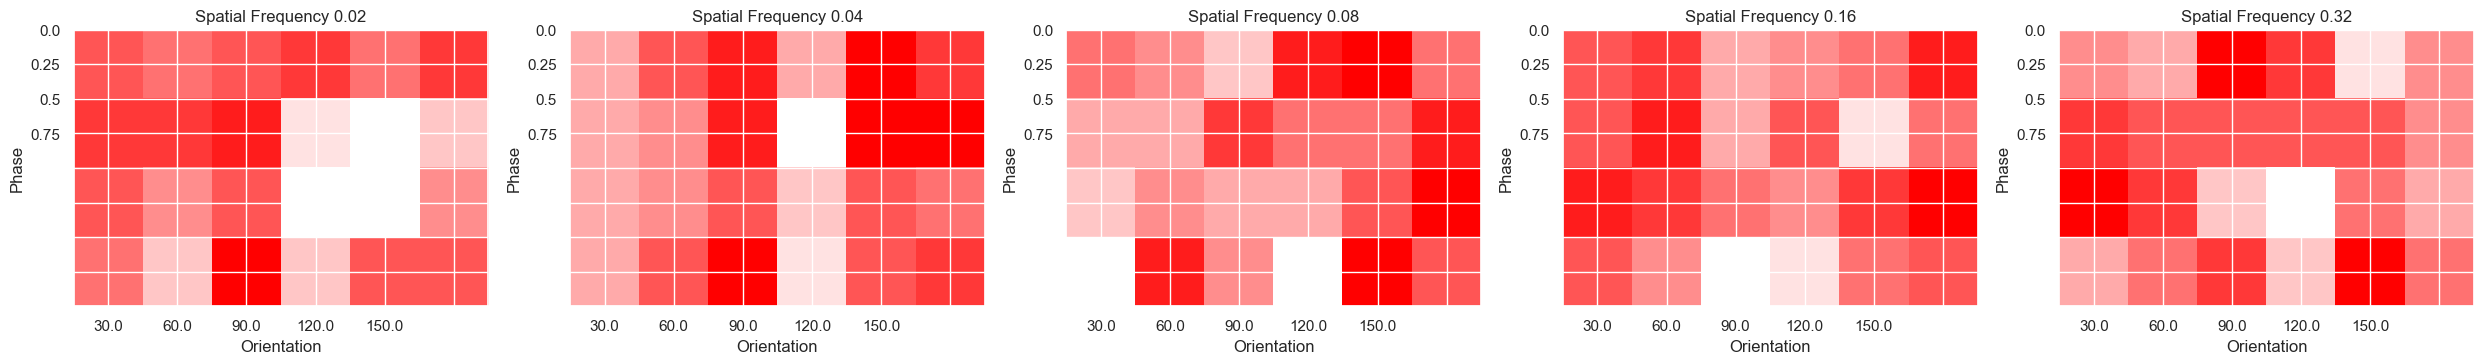

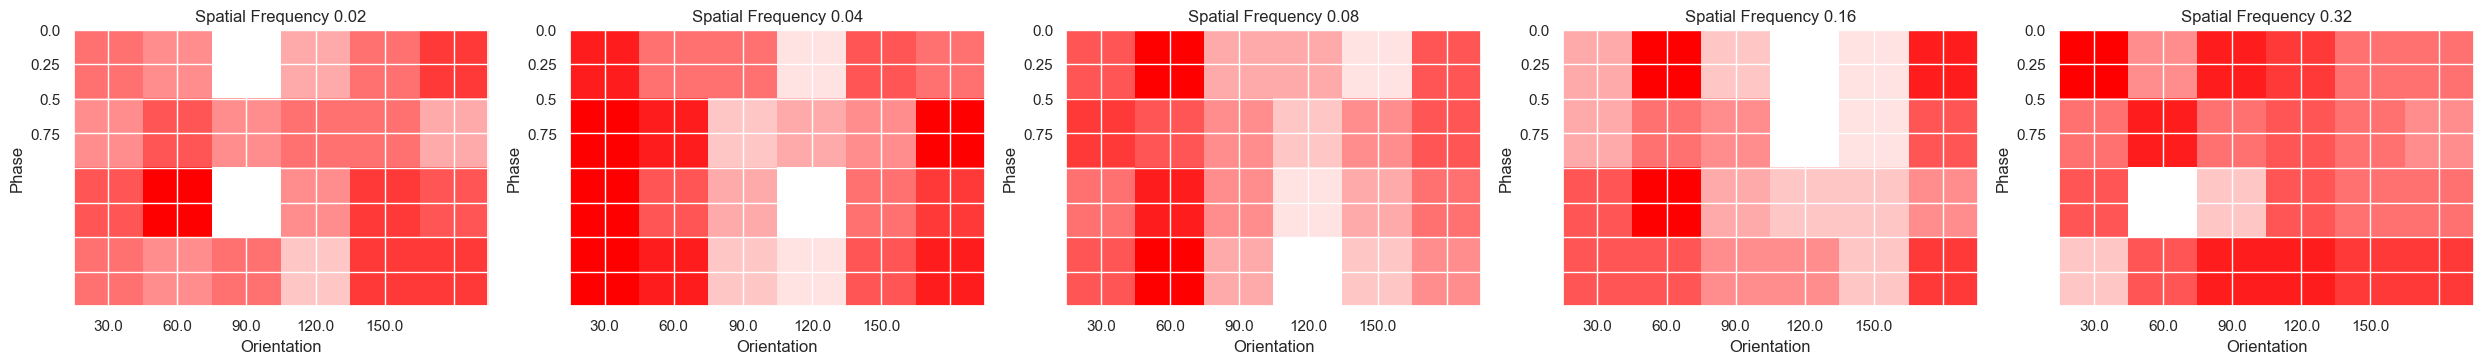

In [121]:
plot_by_spatial_frequency(matrix_visam)
plot_by_spatial_frequency(matrix_visp)
plot_by_spatial_frequency(matrix_visal)
plot_by_spatial_frequency(matrix_visrl)
plot_by_spatial_frequency(matrix_visl)

In [122]:
def plot_by_orientation(matrix):
    num_items = len(unique_orientation_items)
    fig, axes = plt.subplots(1, num_items, figsize=(num_items * 5, 5))  # Adjust figsize as needed

    colors = [(1, 1, 1), (1, 0, 0)]  # white to red
    cm = mcolors.LinearSegmentedColormap.from_list("CustomRed", colors, N=10)

    for i in range(num_items):
        ax = axes[i]
        ax.imshow(matrix[:, i, :], cmap=cm, interpolation='nearest')
        ax.set_xlabel('Spatial Frequency')
        ax.set_ylabel('Phase')
        ax.set_title(f'Orientation {unique_orientation_items[i]}')  # Add a title if needed
        ax.set_xticklabels(unique_spatial_frequency_items)
        ax.set_yticklabels(unique_phase_items)

    plt.tight_layout()  # Adjust subplot parameters to give specified padding.
    plt.show()


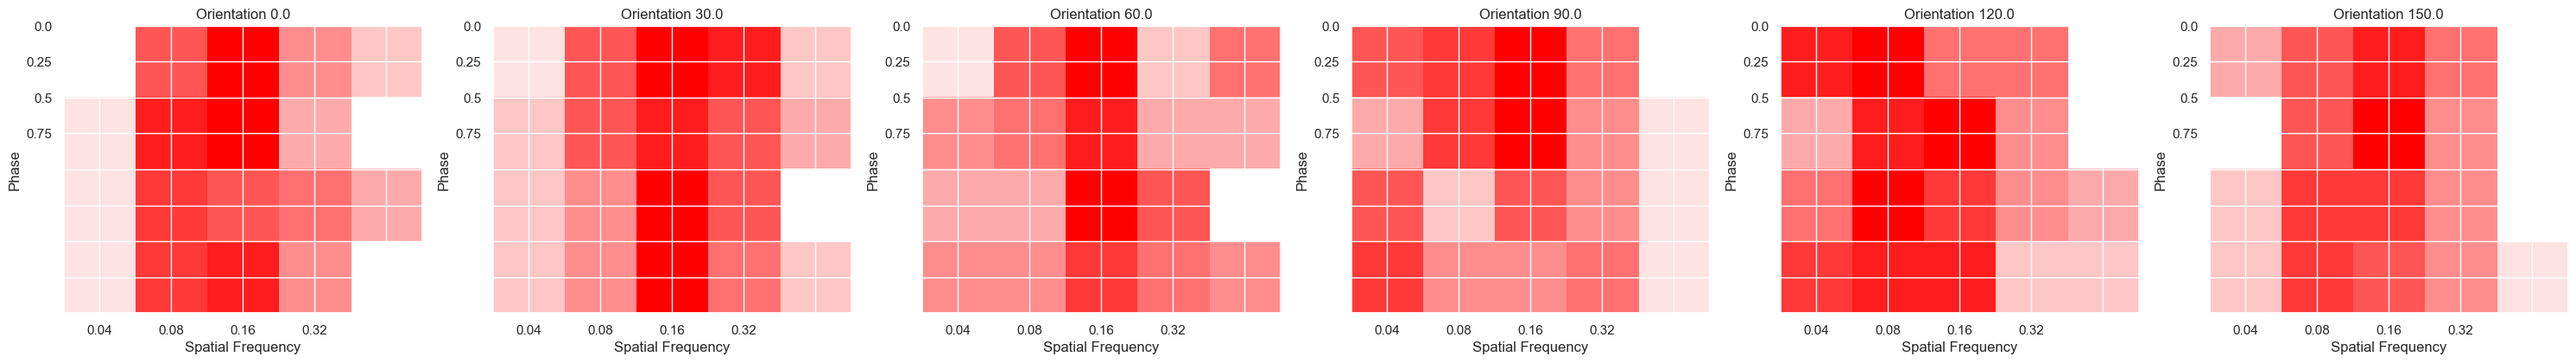

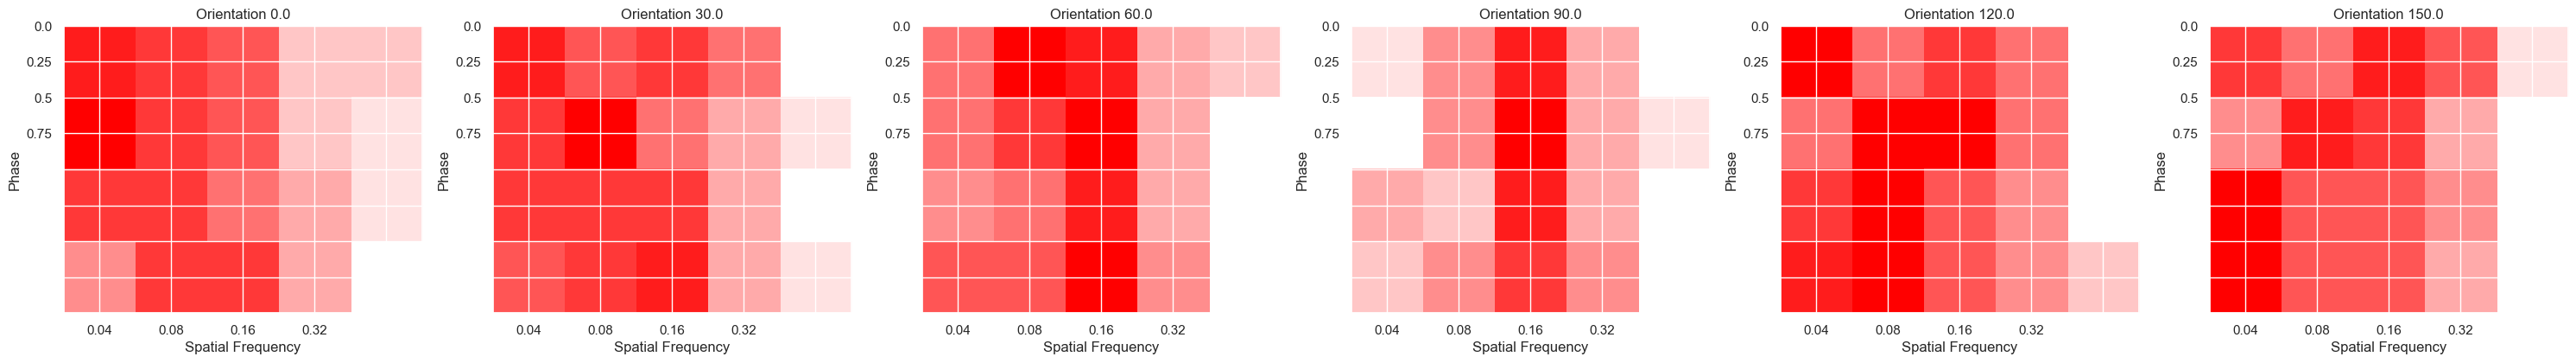

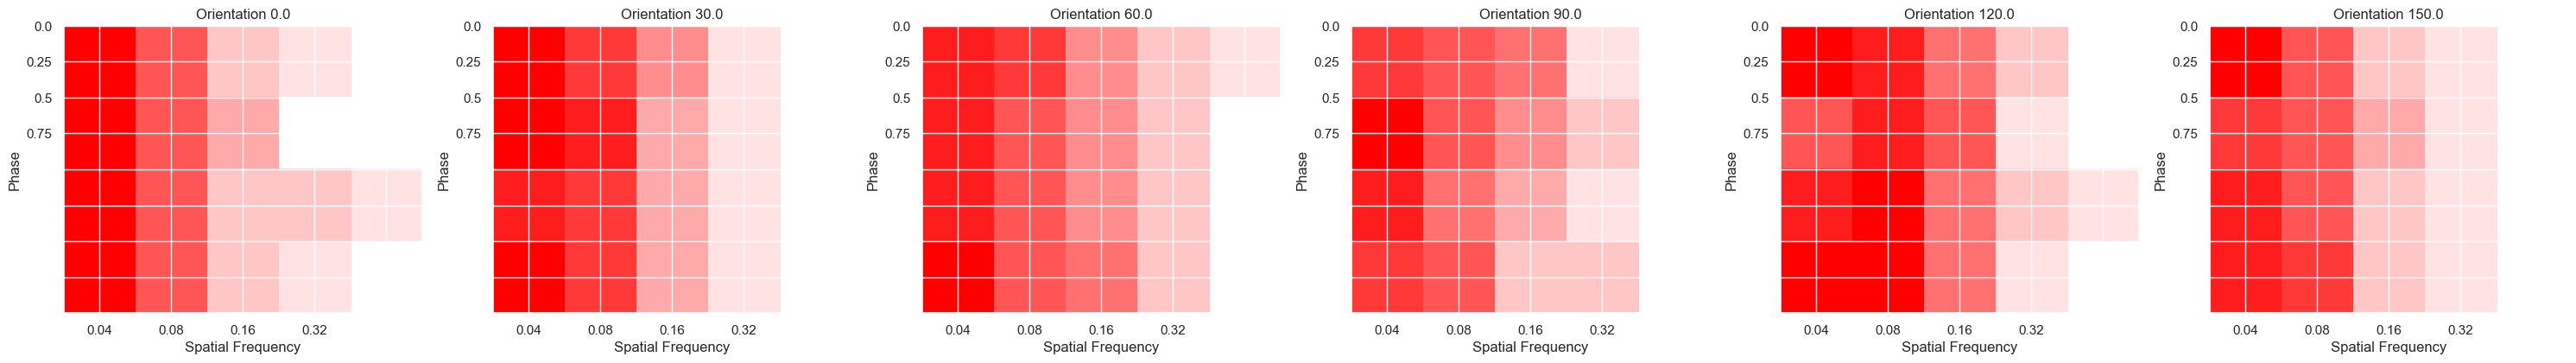

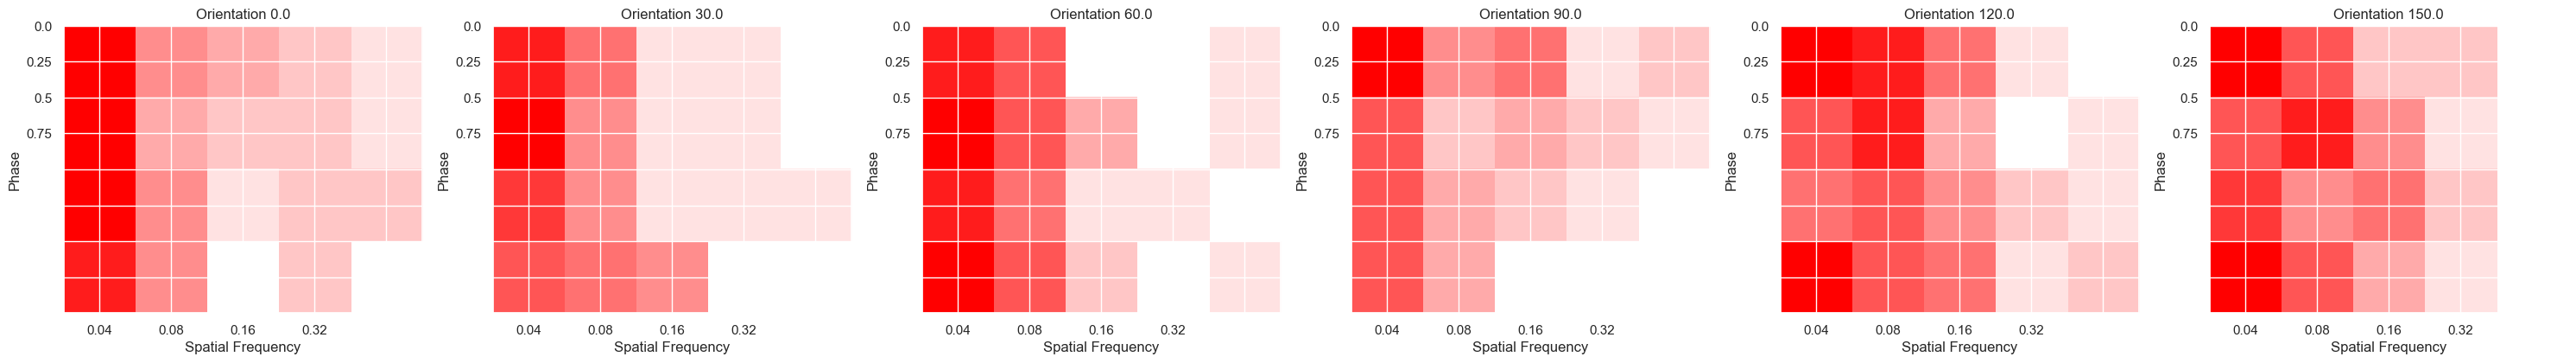

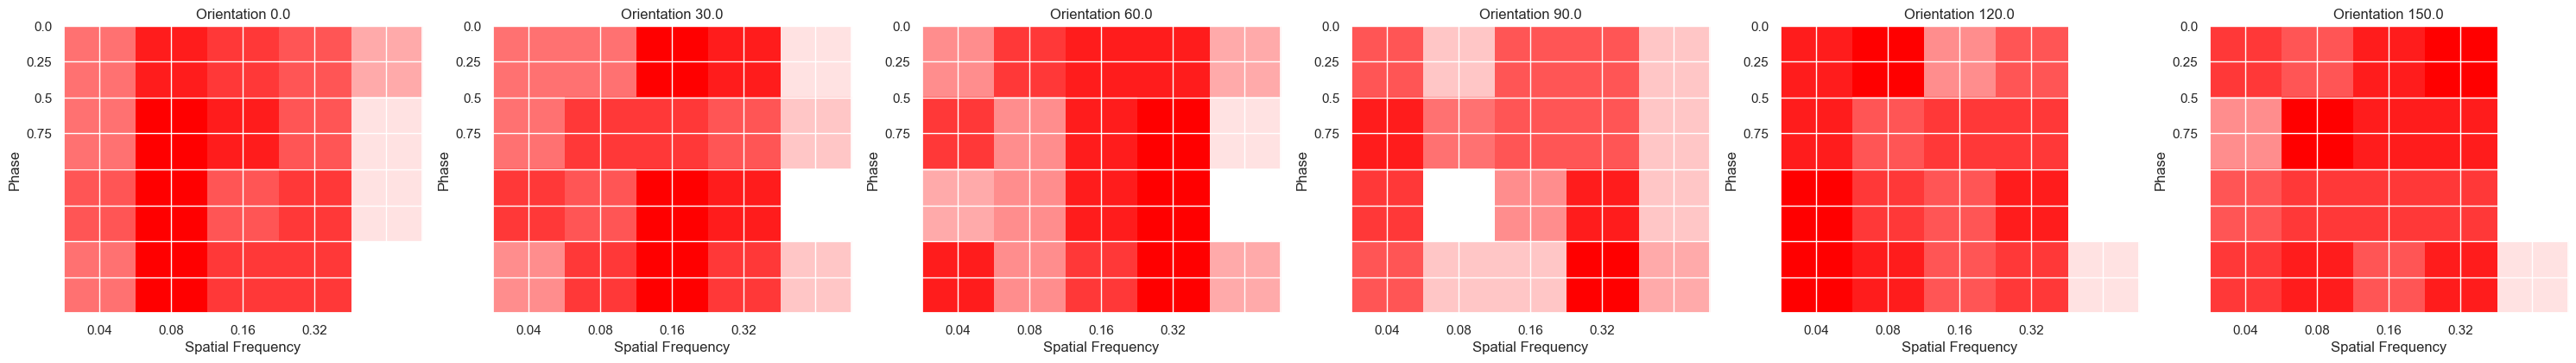

In [123]:
plot_by_orientation(matrix_visam)
plot_by_orientation(matrix_visp)
plot_by_orientation(matrix_visal)
plot_by_orientation(matrix_visrl)
plot_by_orientation(matrix_visl)

In [124]:
def plot_by_phase(matrix):
    num_items = len(unique_phase_items)
    fig, axes = plt.subplots(1, num_items, figsize=(num_items * 5, 5))  # Adjust figsize as needed

    colors = [(1, 1, 1), (1, 0, 0)]  # white to red
    cm = mcolors.LinearSegmentedColormap.from_list("CustomRed", colors, N=10)

    for i in range(num_items):
        ax = axes[i]
        ax.imshow(matrix[i, :, :], cmap=cm, interpolation='nearest')
        ax.set_xlabel('Spatial Frequency')
        ax.set_ylabel('Orientation')
        ax.set_title(f'Phase {unique_phase_items[i]}')  # Add a title if needed
        ax.set_xticklabels(unique_spatial_frequency_items)
        ax.set_yticklabels(unique_orientation_items)

    plt.tight_layout()  # Adjust subplot parameters to give specified padding.
    plt.show()


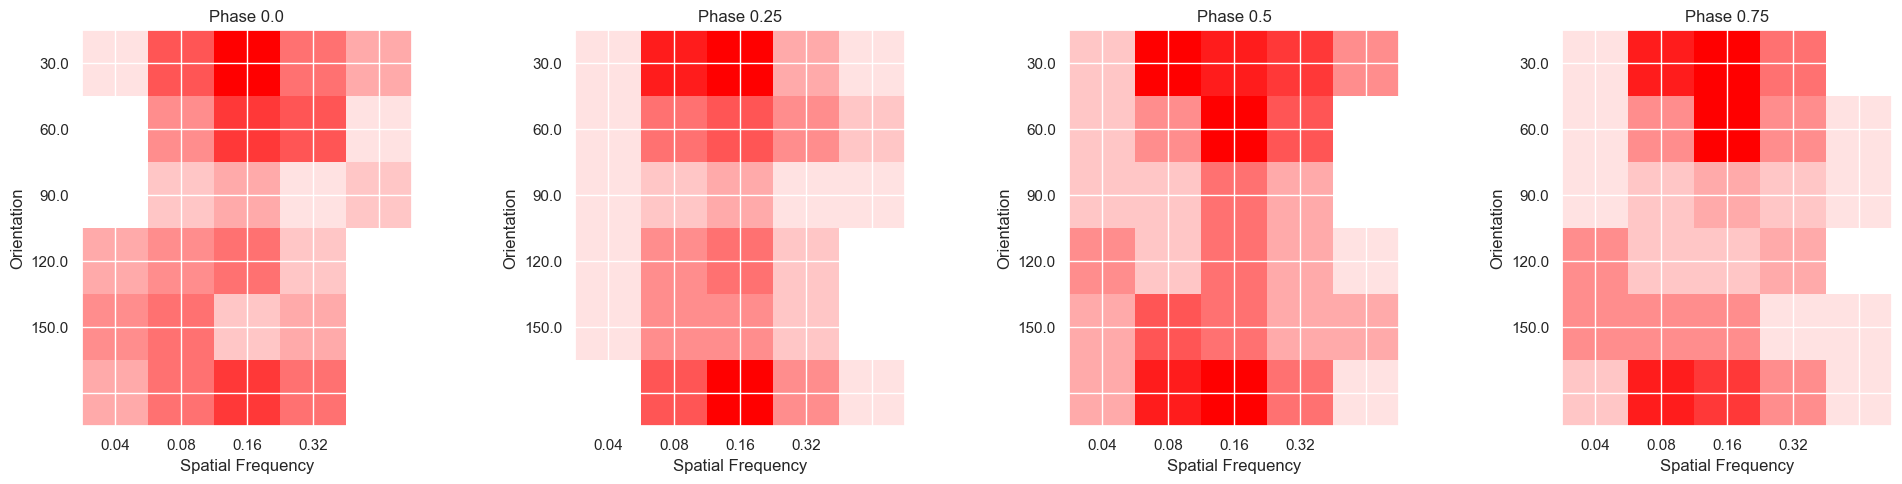

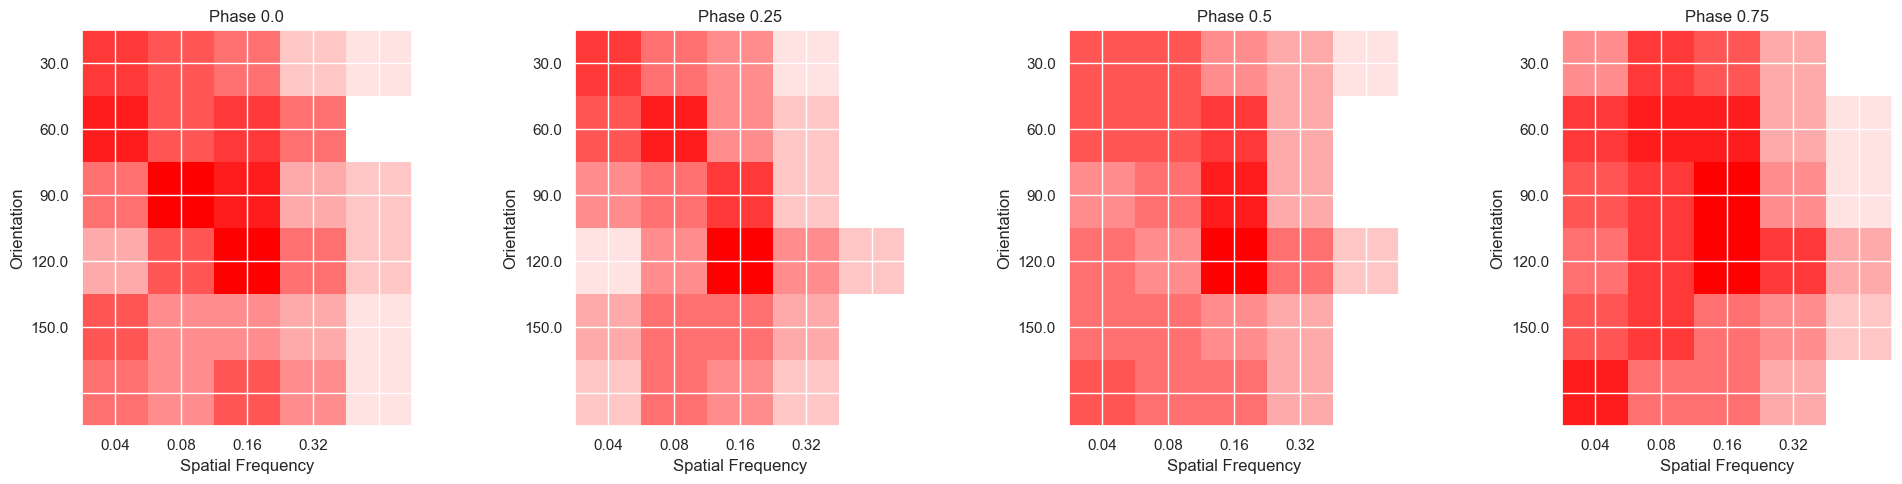

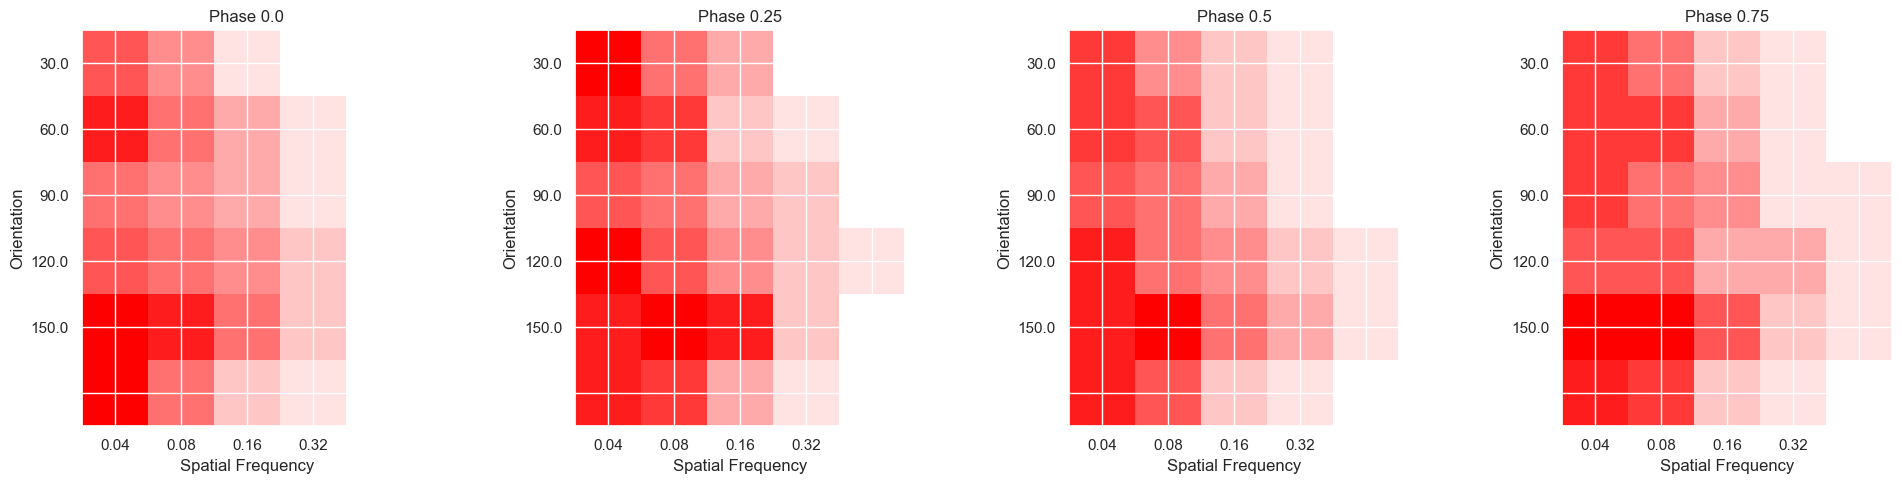

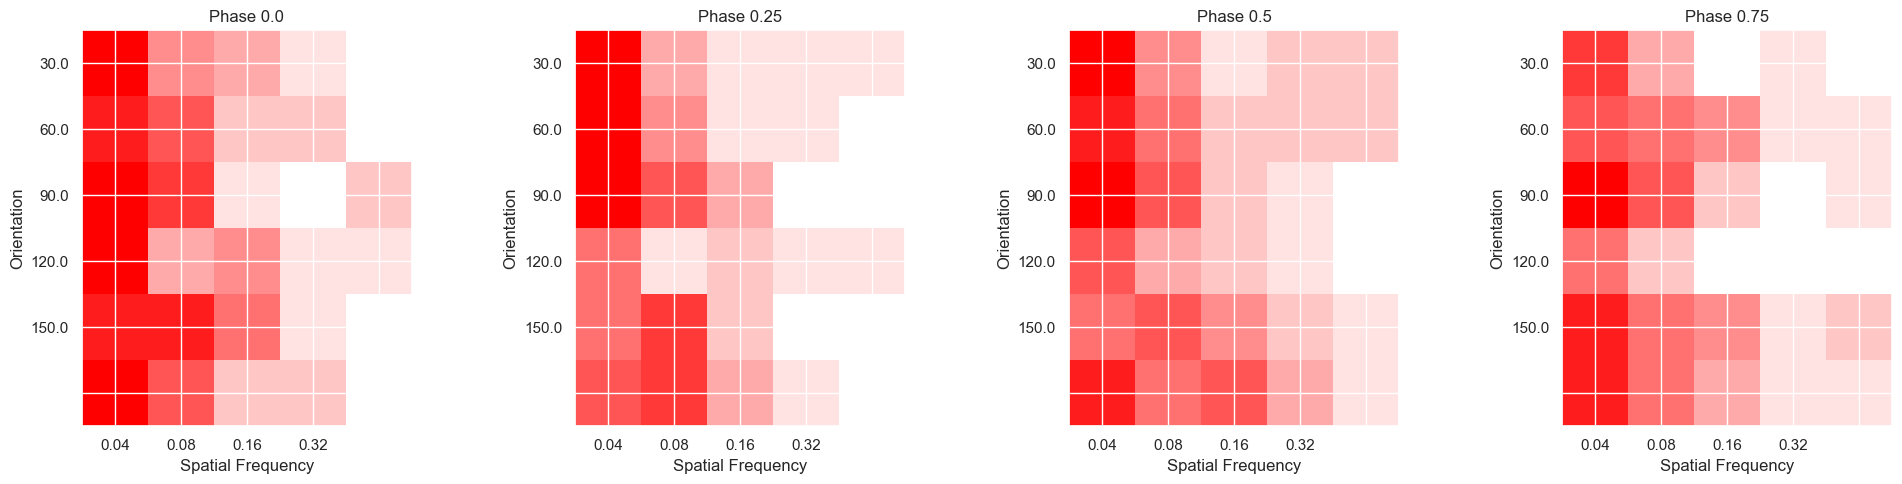

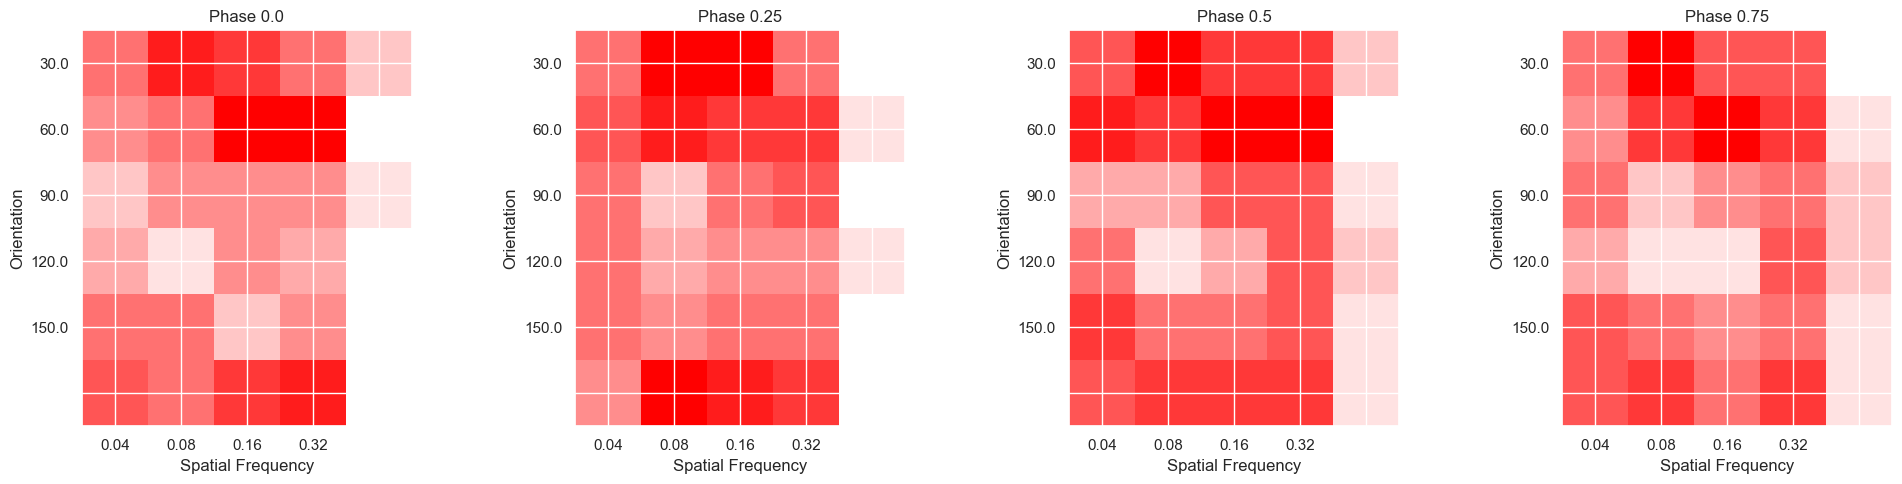

In [125]:
plot_by_phase(matrix_visam)
plot_by_phase(matrix_visp)
plot_by_phase(matrix_visal)
plot_by_phase(matrix_visrl)
plot_by_phase(matrix_visl)